In [1]:
import sys
sys.path.append('../')
from illustris_frb import exp_simulation
from illustris_frb.xcorr import cross_power_estimator, get_Clerr, cross_oqe
from illustris_frb.regions import regions

import numpy as np
import pandas as pd
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

In [2]:
colorcycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.style.use({
    'font.family':        'serif',
    'font.serif':         ['DejaVu Sans'],
    'mathtext.fontset':   'stixsans',
    'figure.figsize':     (6,4),
    'lines.markersize':   1.5,
    'text.usetex':        False,
    'figure.dpi':         120,
    'savefig.dpi':        250,
    'savefig.bbox':       'tight',
    'savefig.pad_inches': 0.1,
    'axes.prop_cycle':    plt.cycler('color', colorcycle)
})

In [3]:
# plot cross-correlation power spectrum

def plot_xcorr(ells, C_ls, ax=None, label=None, color='k', lw=1, 
               ylim=None, DeltaCs=None, xlabel=r'$\ell$',
               ylabel=r'$C_l^{Dg}$', alpha=1, xscale='log', yscale='log', **kwargs):
    
    # delta_gs = N_gs/np.mean(N_gs) - 1
    # ells, C_ls = cross_power_estimator(tot_DM, delta_gs, res, delta_ell=delta_ell)

    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(ells, C_ls, lw=lw, color=color, label=label, **kwargs)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    ax.set_xlim((ells[0], ells[-1]))
    ax.set_ylim(ylim)

    if DeltaCs is not None:
        ax.fill_between(ells, C_ls-DeltaCs, C_ls+DeltaCs, color=color, alpha=alpha*0.2)

def plot_xcorr_trials(ells, C_l_list, ax=None, **kwargs):
    C_l_arr = np.vstack(C_l_list)
    mean_Cl = np.mean(C_l_arr, axis=0)
    std_Cl = np.std(C_l_arr, axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    plot_xcorr(ells, mean_Cl, ax=ax, DeltaCs=std_Cl, **kwargs)

In [4]:
def sfunc(DMs, a=1): # fiducial selection function
    # a is how many factors to squish the selection function
    return np.exp( -(2/3)*(np.log10(DMs*a)-3)**2 )

In [5]:
origin = 500 * np.array([50, 70, 23])
sim = exp_simulation(origin, reg_name='A1')

frb_zrange = (0.3, 0.4)
frb_mean_x = np.mean(sim.comoving_distance(frb_zrange))

g_zrange = (0, 0.2)

host_df = sim.read_shell_galaxies(frb_zrange)
sfr_weight = host_df['SFR']**0.9 / (1 + sim.z_from_dist(host_df['x']))

In [6]:
nbins=10
n_frbs = 3000

N_g = sim.Ngal_grid(zrange=g_zrange)
delta_g = (N_g - np.mean(N_g)) / np.mean(N_g)

midslice_DM = sim.DM_grid(x_max=frb_mean_x)
ells, midslice_ClDg = cross_power_estimator(midslice_DM, delta_g, s=0.0008, nbins=nbins)
midslice_DeltaCs = get_Clerr(midslice_DM, N_g, nbins=nbins)

full_DM = sim.DM_grid()

## examining properties of region A1

Text(0, 0.5, 'DM (pc cm$^{-3}$)')

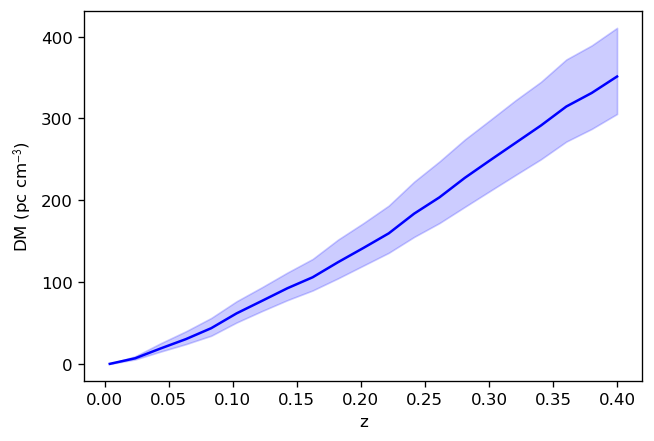

In [16]:
#DM vs z

zs = np.linspace(0.004, 0.4, 21)
DMs = []
for z in zs:
    DM = sim.DM_grid(x_max=sim.comoving_distance(z))
    DMs.append(np.array((np.percentile(DM, 25), np.median(DM), np.percentile(DM, 75))))

DMs = np.vstack(DMs)
plt.plot(zs, DMs[:,1], color='b')
plt.fill_between(zs, DMs[:,0], DMs[:,2], alpha=0.2, color='b')
plt.xlabel('z')
plt.ylabel('DM (pc cm$^{-3}$)')

In [47]:
all_g_df = sim.read_shell_galaxies()

In [ ]:
all_g_df.size

72037180

fraction of star-forming galaxies: 348231/72037180 = 0.0048


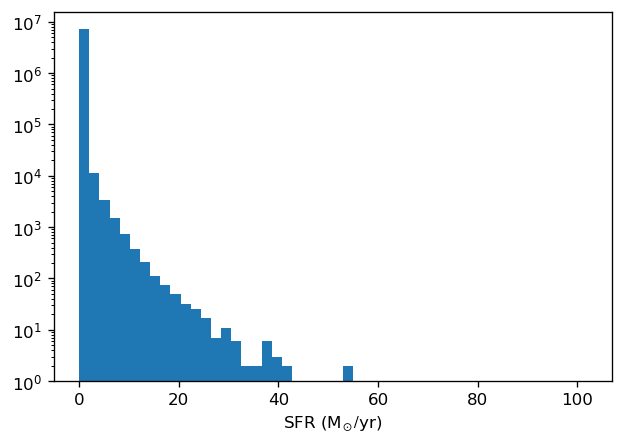

In [ ]:
plt.hist(all_g_df['SFR'], bins=50)
plt.yscale('log')
plt.ylim(bottom=1)
plt.xlabel('SFR (M$_\odot/$yr)')

print(f'fraction of star-forming galaxies: {np.count_nonzero(all_g_df["SFR"] > 0)}/{all_g_df.size} = {np.count_nonzero(all_g_df["SFR"] > 0)/all_g_df.size:.4f}')

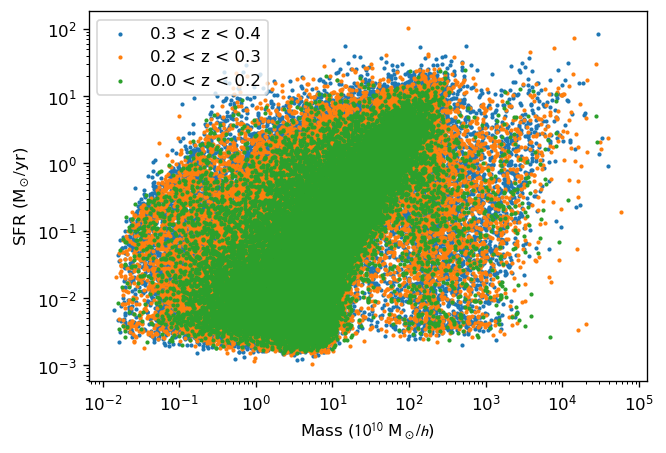

In [ ]:
for zrange in ((0.3, 0.4), (0.2, 0.3), (0, 0.2)):
    xrange = sim.comoving_distance (zrange)
    df = all_g_df[ (xrange[0] < all_g_df['x']) & (all_g_df['x'] <= xrange[1]) ]
    plt.scatter(df['Mass'][df['SFR'] > 0], df['SFR'][df['SFR'] > 0], label=f'{zrange[0]:.1f} < z < {zrange[1]:.1f}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass ($10^{10}$ M$_\odot/h$)')
plt.ylabel(r'SFR (M$_\odot/$yr)')

plt.legend(loc='upper left')

In [ ]:
np.linspace(0, 0.4, 5)

array([0. , 0.1, 0.2, 0.3, 0.4])

Text(0, 0.5, 'SFR (M$_\\odot/$yr)')

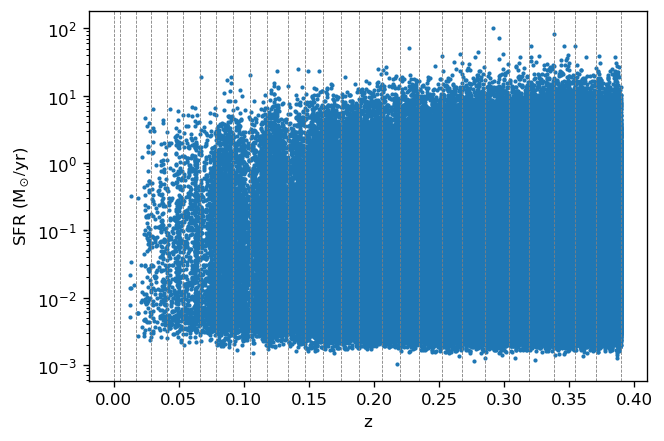

In [ ]:
for xlim in np.flip(sim.all_snap_xlims):
    z = sim.z_from_dist(xlim)
    if z >= 0.4:
        break
    plt.axvline(x=z, color='gray', ls='--', lw=0.5)

plt.scatter(sim.z_from_dist(np.array(all_g_df['x'][all_g_df['SFR'] > 0])), all_g_df['SFR'][all_g_df['SFR'] > 0])
plt.yscale('log')

plt.xlabel('z')
plt.ylabel('SFR (M$_\odot/$yr)')

Text(0.5, 0, 'z')

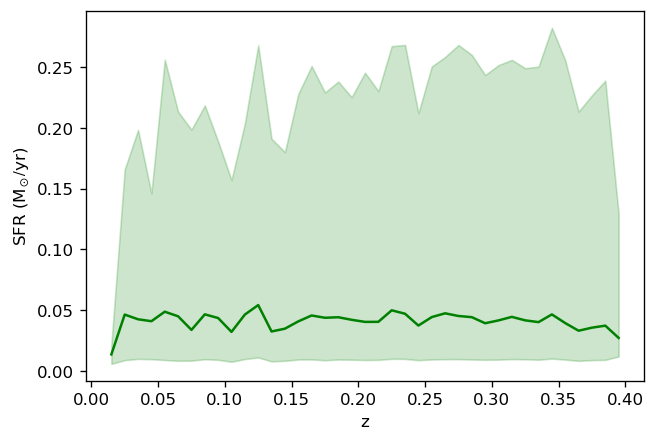

In [ ]:
bins=np.linspace(0, 0.4, 41)
zs = sim.z_from_dist(np.array(all_g_df['x'][all_g_df['SFR'] > 0]))
SFRs = all_g_df['SFR'][all_g_df['SFR'] > 0]
median_SFR = binned_statistic(zs, SFRs, statistic='median', bins=bins)[0]
lower_SFR = binned_statistic(zs, SFRs, statistic=lambda x: np.percentile(x, 25), bins=bins)[0]
upper_SFR = binned_statistic(zs, SFRs, statistic=lambda x: np.percentile(x, 75), bins=bins)[0]

z_mids = np.convolve(bins, [0.5,0.5], 'valid')
plt.plot(z_mids, median_SFR, color='g')
plt.fill_between(z_mids, lower_SFR, upper_SFR, color='g', alpha=0.2)

plt.ylabel('SFR (M$_\odot/$yr)')
plt.xlabel('z')


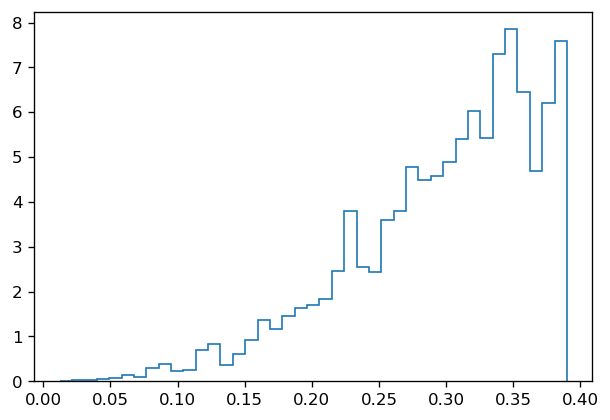

In [ ]:
df = all_g_df[all_g_df['SFR'] > 0]
_ = plt.hist(sim.z_from_dist(np.array(df['x'])), weights=df['SFR'], density=True, bins=41, histtype='step')

## what happens when there's a redshift overlap?

### test overlaps

In [11]:
zrange = (0,0.4)
meanx = np.mean(sim.comoving_distance(zrange))
ntrials = 10
n_frbs = 3000

overlap_host_df = sim.read_shell_galaxies(zrange)
overlap_weight = overlap_host_df['SFR']**0.9

midslice_DM_overlap = sim.DM_grid(x_max=meanx)

N_gs = []
delta_gs = []
g_zranges = ((0, 0.1), (0, 0.2), (0, 0.3), (0, 0.4))
for g_zrange_ in g_zranges:
    N_g_ = sim.Ngal_grid(zrange=g_zrange_)
    delta_g_ = (N_g_ - np.mean(N_g_)) / np.mean(N_g_)
    N_gs.append(np.array(N_g_))
    delta_gs.append(np.array(delta_g_))

In [12]:

ClDgs_overlap = {}
midslice_ClDgs_overlap = {}
fullz_ClDgs = {}

for i, g_zrange_ in enumerate(g_zranges):
    ells, ClDg = cross_power_estimator(midslice_DM_overlap, delta_gs[i], nbins=nbins)
    DeltaCs = get_Clerr(midslice_DM_overlap, N_gs[i], nbins=nbins)
    midslice_ClDgs_overlap[g_zrange_] = (np.array(ClDg), np.array(DeltaCs))

    ells, ClDg = cross_power_estimator(full_DM, delta_gs[i], nbins=nbins)
    DeltaCs = get_Clerr(midslice_DM_overlap, N_gs[i], nbins=nbins)
    fullz_ClDgs[g_zrange_] = (np.array(ClDg), np.array(DeltaCs))

    ClDgs_overlap[g_zrange_] = []
    for _ in range(ntrials):
        DM, mult = sim.sim_DM_grid(N=n_frbs, g_df=overlap_host_df, weights=overlap_weight)
        ells, ClDg = cross_oqe(DM, delta_gs[i], mult, nbins=nbins)
        ClDgs_overlap[g_zrange_].append(ClDg)

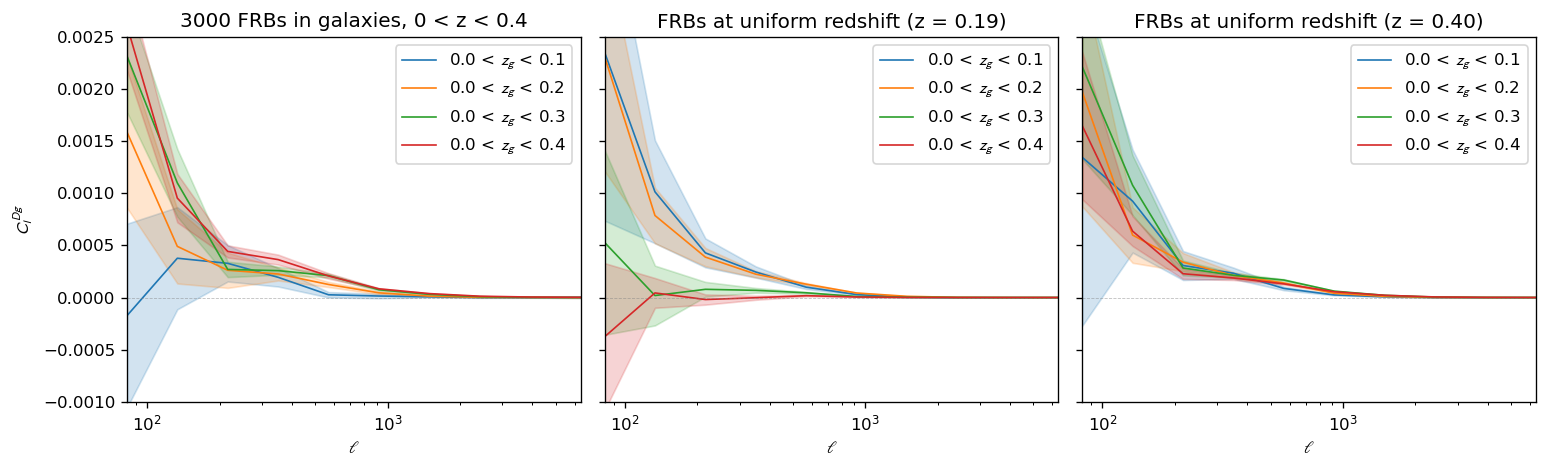

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True)

ax = axes[0]
ax.set_title(f'{n_frbs} FRBs in galaxies, 0 < z < 0.4')
for i, g_zrange_ in enumerate(g_zranges):
    label = f'{g_zrange_[0]:.1f} < $z_g$ < {g_zrange_[1]:.1f}'
    plot_xcorr_trials(ells, ClDgs_overlap[g_zrange_], color=colorcycle[i], ax=ax, label=label, lw=1, yscale='linear')
ax.axhline(0, ls='--', c='gray', alpha=0.5, lw=0.5)
ax.legend()

zs = (sim.z_from_dist(meanx), 0.4)
for i, result in enumerate((midslice_ClDgs_overlap, fullz_ClDgs)):
    ax = axes[i+1]
    ax.set_title(f'FRBs at uniform redshift (z = {zs[i]:.2f})')
    for i, g_zrange_ in enumerate(g_zranges):
        label = f'{g_zrange_[0]:.1f} < $z_g$ < {g_zrange_[1]:.1f}'
        ClDg_, DeltaCs_ = result[g_zrange_]
        plot_xcorr(ells, ClDg_, DeltaCs=DeltaCs_, color=colorcycle[i], ax=ax, label=label, lw=1, yscale='linear')
    ax.set_ylabel('')
    ax.axhline(0, ls='--', c='gray', alpha=0.5, lw=0.5)
    ax.legend()

ax.set_ylim(-0.001, 0.0025)
plt.tight_layout()

## how many FRBs do we need?

In [79]:
# average number of FRBs per region for CHIME 2 -like catalog

2000 / (4*np.pi) * sim.region.size**2

1.5915494309189537

In [96]:
nbins=10
midslice_DM = sim.DM_grid(x_max=frb_mean_x)
ells, midslice_ClDg = cross_power_estimator(midslice_DM, delta_g, s=0.0008, nbins=nbins)
midslice_DeltaCs = get_Clerr(midslice_DM, N_g, nbins=nbins)

In [16]:
ntrials = 10
ClDgs_nfrbs = {}
ClDgs_nfrbs_midslice = {}
n_frbs_list = [100, 500, 1000, 2000, 3000]
for n_frbs in n_frbs_list:
    print(n_frbs)
    ClDgs_nfrbs[n_frbs], ClDgs_nfrbs_midslice[n_frbs] = [], []
    for _ in range(ntrials):
        DM, mult = sim.sim_DM_grid(N=n_frbs, g_df=host_df, weights=sfr_weight)
        ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
        ClDgs_nfrbs[n_frbs].append(ClDg)

        mult_inds = np.random.choice(len(DM)**2, n_frbs)
        mult = np.bincount(mult_inds, minlength=len(DM)**2).reshape(DM.shape)
        DM = np.where(mult > 0, midslice_DM, 0)
        ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
        ClDgs_nfrbs_midslice[n_frbs].append(ClDg)

100
500
1000
2000
3000


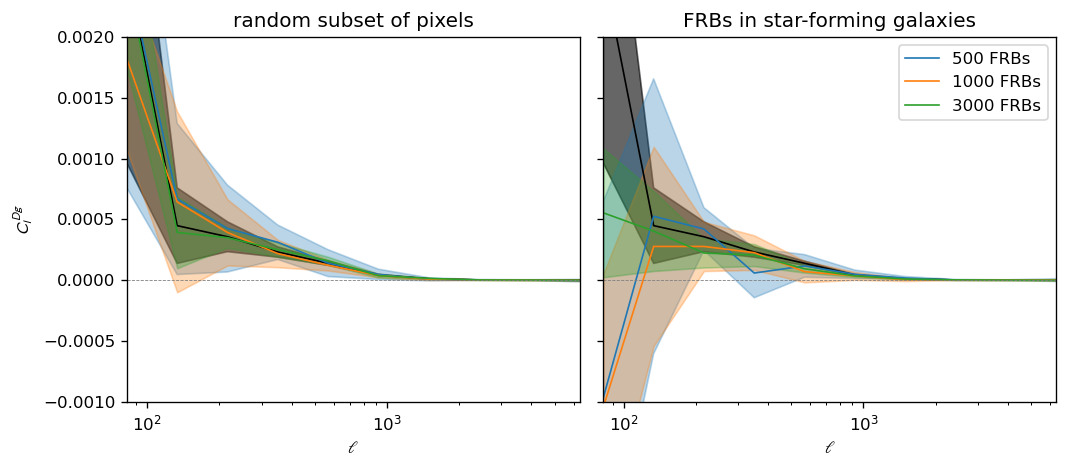

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)

titles = ('random subset of pixels', 'FRBs in star-forming galaxies')
for j, results in enumerate([ClDgs_nfrbs_midslice, ClDgs_nfrbs]):
    ax = axes[j]
    ax.set_title(titles[j])
    plot_xcorr(ells, midslice_ClDg, DeltaCs=midslice_DeltaCs, ax=ax, color='k', yscale='linear', alpha=3)
    for i, n_frbs in enumerate((500, 1000, 3000)):
        plot_xcorr_trials(ells, results[n_frbs], ax=ax, label=f'{n_frbs} FRBs', yscale='linear', color=colorcycle[i], alpha=1.5)
    ax.axhline(0, color='gray', ls='--', lw=0.5)
    ax.set_ylim(-0.001, 0.002)
axes[1].set_ylabel('')
ax.legend()
plt.tight_layout()

In [118]:
# same thing but with mass-weighting

ClDgs_nfrbs_mweight = {}
for n_frbs in n_frbs_list:
    print(n_frbs)
    ClDgs_nfrbs_mweight[n_frbs] = []
    for _ in range(ntrials):
        DM, mult = sim.sim_DM_grid(N=n_frbs, g_df=host_df, weights='Mass')
        mult[mult > 1] = 1
        ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
        ClDgs_nfrbs_mweight[n_frbs].append(ClDg)

100
500
1000
2000
3000


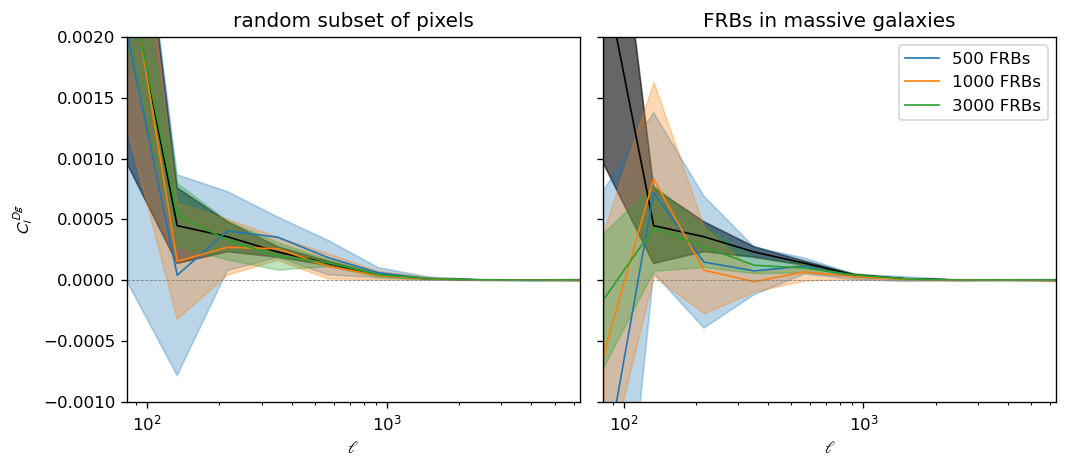

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)

titles = ('random subset of pixels', 'FRBs in massive galaxies')
for j, results in enumerate([ClDgs_nfrbs_midslice, ClDgs_nfrbs_mweight]):
    ax = axes[j]
    ax.set_title(titles[j])
    plot_xcorr(ells, midslice_ClDg, DeltaCs=midslice_DeltaCs, ax=ax, color='k', yscale='linear', alpha=3)
    for i, n_frbs in enumerate((500, 1000, 3000)):
        if n_frbs == 2000:
            continue
        plot_xcorr_trials(ells, results[n_frbs], ax=ax, label=f'{n_frbs} FRBs', yscale='linear', color=colorcycle[i], alpha=1.5)
    ax.axhline(0, color='gray', ls='--', lw=0.5)
    ax.set_ylim(-0.001, 0.002)
axes[1].set_ylabel('')
ax.legend()
plt.tight_layout()

## non-gaussianities

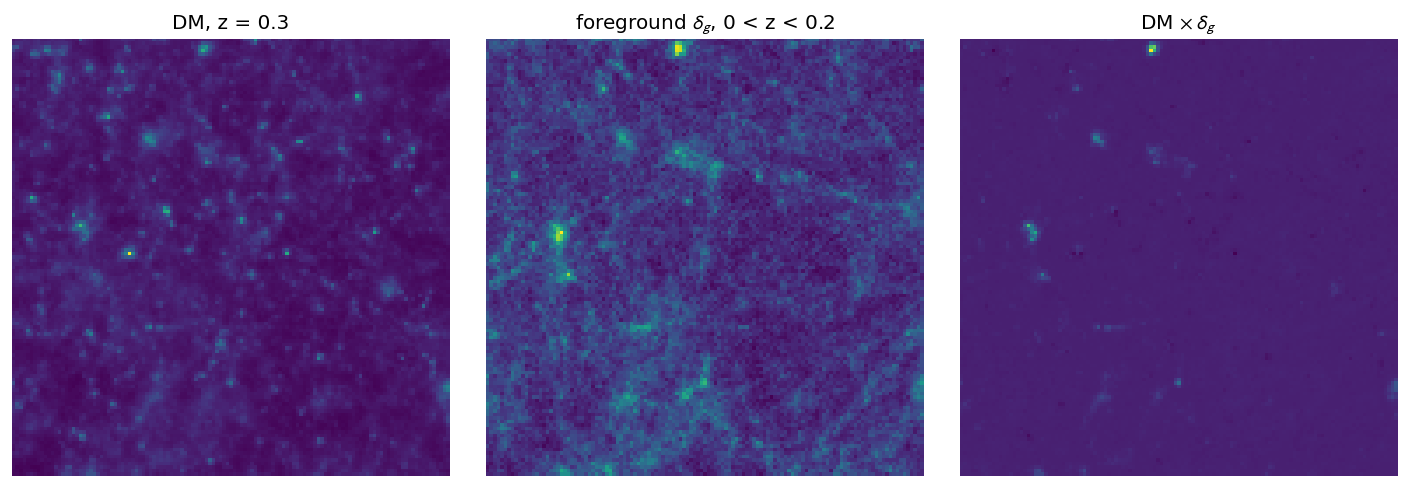

In [51]:
g_zrange = (0, 0.2)
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax in axes:
    ax.axis('off')

ax = axes[0]
norm_midslice_DM = midslice_DM - np.mean(midslice_DM)
ax.imshow(norm_midslice_DM)
ax.set_title(f'DM, z = {sim.z_from_dist(frb_mean_x):.1f}')

ax = axes[1]
ax.imshow(delta_g)
ax.set_title(r'foreground $\delta_g$, ' + f'{g_zrange[0]} < z < {g_zrange[1]}')

ax = axes[2]
ax.imshow(norm_midslice_DM * delta_g)
ax.set_title(r'DM $\times ~ \delta_g$')

plt.tight_layout()

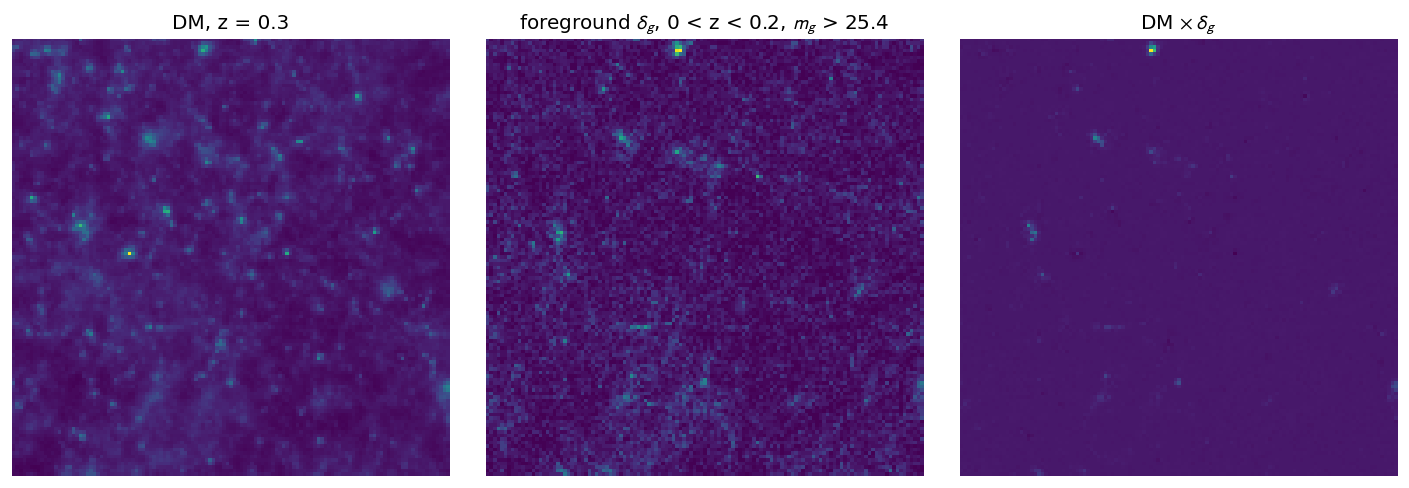

In [52]:
# repeat with an apparent magnitude cut

m_g_cutoff = 25.4
N_g_cutoff = sim.Ngal_grid(zrange=g_zrange, m_g_cutoff=m_g_cutoff)
delta_g_cutoff = (N_g_cutoff - np.mean(N_g_cutoff)) / np.mean(N_g_cutoff)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax in axes:
    ax.axis('off')

ax = axes[0]
ax.imshow(norm_midslice_DM)
ax.set_title(f'DM, z = {sim.z_from_dist(frb_mean_x):.1f}')

ax = axes[1]
ax.imshow(delta_g_cutoff)
ax.set_title(r'foreground $\delta_g$, ' + f'{g_zrange[0]} < z < {g_zrange[1]}, $m_g$ > {m_g_cutoff}')

ax = axes[2]
ax.imshow(norm_midslice_DM * delta_g_cutoff)
ax.set_title(r'DM $\times ~ \delta_g$')

plt.tight_layout()

Text(0.5, 19.466666666666665, 'DM $\\times ~ \\delta_g$')

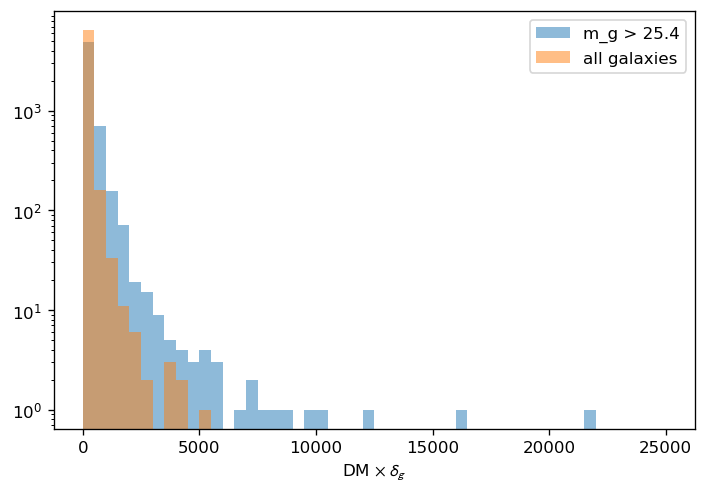

In [41]:
bins = np.linspace(0, 25000, 51)
fig, ax = plt.subplots()
H = ax.hist((midslice_DM * delta_g_cutoff).flatten(), bins=bins, alpha=0.5, label='m_g > 25.4')
plt.yscale('log')
H = ax.hist((midslice_DM * delta_g).flatten(), bins=bins, alpha=0.5, label='all galaxies')
plt.tight_layout()
plt.legend()
plt.xlabel(r'DM $\times ~ \delta_g$')

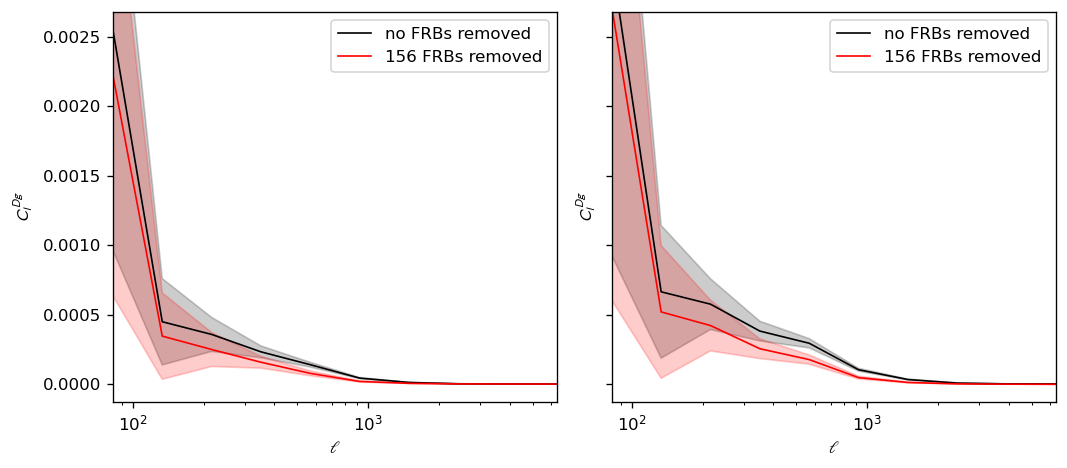

In [68]:
fig, axes = plt.subplots(1,2, figsize=(9,4), sharex=True, sharey=True)

tot_n = sim.region.nside**2
n_remove = int(tot_n // 100)
for i, (N_g_, delta_g_) in enumerate(((N_g, delta_g), (N_g_cutoff, delta_g_cutoff))):
    ax = axes[i]

    ells, ClDg = cross_power_estimator(midslice_DM, delta_g_, nbins=nbins)
    DeltaCs = get_Clerr(midslice_DM, N_g_, nbins=nbins)
    plot_xcorr(ells, ClDg, DeltaCs=DeltaCs, ax=ax, color='k', yscale='linear', label='no FRBs removed')

    mask = np.ones_like(midslice_DM)
    DMdg = norm_midslice_DM * delta_g_
    mask[np.unravel_index(np.argpartition(DMdg, tot_n - n_remove, axis=None)[-n_remove:], DMdg.shape)] = 0
    ells, ClDg = cross_oqe(midslice_DM*mask, delta_g_, mask, nbins=nbins)
    plot_xcorr(ells, ClDg, DeltaCs=DeltaCs, ax=ax, color='r', yscale='linear', label=f'{n_remove} FRBs removed')

    ax.legend()

plt.tight_layout()

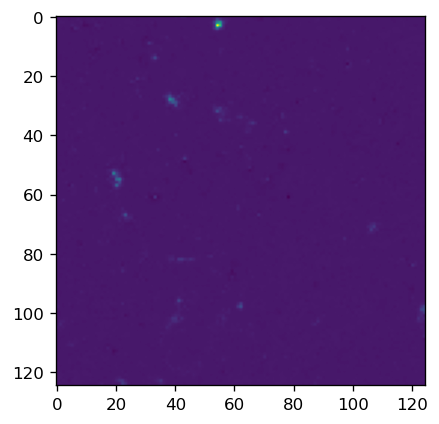

In [71]:
plt.imshow(DMdg)

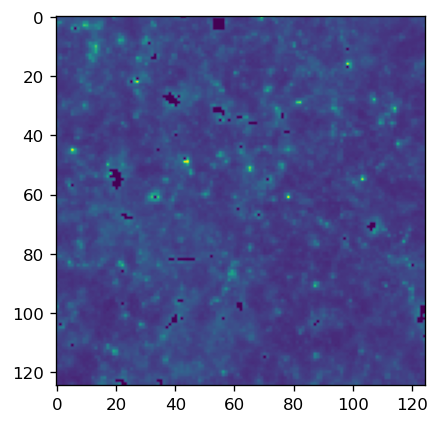

In [74]:
plt.imshow(midslice_DM*mask)

## intervening galaxy impact parameter selection effects

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
def P_scattering(fg_galaxy_bs, r50 = 8*sim.h): #50% probability at 8 kpc, 1 - 2**(-r/r50)
    Ps = 1 - np.power(2, -(fg_galaxy_bs/r50)**2)
    return Ps

def scattering_sfunc(host_g_df, fg_g_df_groups, P_scatter_func=P_scattering):
    if 'scatter P' in host_g_df.columns:
        return np.array(host_g_df['scatter P'])
    host_g_df['scatter P'] = 1.
    host_g_df_groups = host_g_df.groupby('ipix', sort=False)[['theta_', 'phi_']]
    for host_ipix in host_g_df_groups.groups.keys():
        host = host_g_df_groups.get_group(host_ipix)
        fg = fg_g_df_groups.get_group(host_ipix)
        cdists = np.array(fg['x']) * np.sin(np.array(fg['theta_'])) * cdist(np.array(host), np.array(fg[['theta_', 'phi_']]))
        # print(np.amin(cdists)*1000/sim.h)
        Ps = P_scatter_func(cdists)
        host_g_df.loc[host.index, 'scatter P'] = np.prod(Ps, axis=1)
    return host_g_df['scatter P']

In [ ]:
ClDgs_sfunc, ClDgs = [], []
ntrials = 1
n = 2000 #FRBs
nbins=20

for reg_name, sim in all_sims.items():

    print(reg_name)

    N_g = sim.Ngal_grid(g_zrange)
    delta_g = N_g/np.mean(N_g) - 1

    host_df = sim.read_shell_galaxies(frb_zrange)

    fg_g_df = sim.read_shell_galaxies((sim.z_from_dist(0.25*frb_mean_x), sim.z_from_dist(0.75*frb_mean_x)))
    fg_g_df_groups = fg_g_df.groupby('ipix', sort=False)[['theta_', 'phi_', 'x']]
    
    for i in range(ntrials):
        (DM_sfunc, mult_sfunc), (DM, mult) = sim.sim_DM_grid(N=n, g_df=host_df, weights='Mass', g_sfunc=lambda x: scattering_sfunc(x, fg_g_df_groups))
        mult_sfunc[mult_sfunc > 1] = 1
        mult[mult > 1] = 1
        ells, ClDg = cross_oqe(DM_sfunc, delta_g, mult_sfunc, nbins=nbins)
        ClDgs_sfunc.append(np.array(ClDg))
        ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
        ClDgs.append(np.array(ClDg))
    
    if reg_name == 'C8':
        break

A1
A2
A3
A4
A5
A6
A7
A8
B1
B2
B3
B4
B5
B6
B7
B8
C1
C2
C3
C4
C5
C6
C7
C8


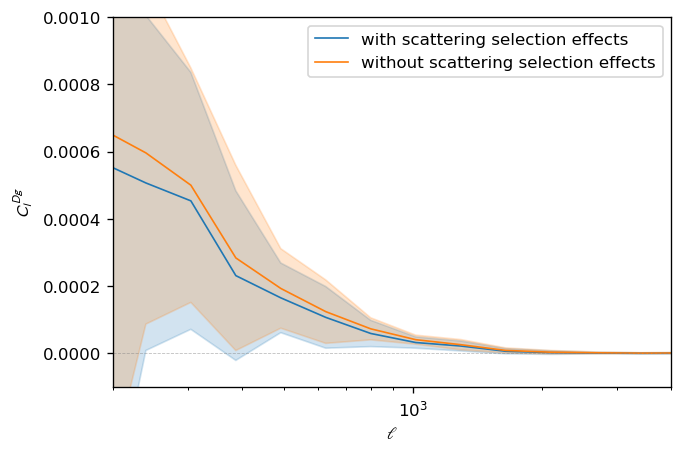

In [ ]:
fig, ax = plt.subplots()

labels = ('with scattering selection effects', 'without scattering selection effects')
for i, results in enumerate((ClDgs_sfunc, ClDgs)):
    plot_xcorr_trials(ells ,results, color=colorcycle[i], ax=ax, label=labels[i], lw=1, yscale='linear')
ax.set_ylim(-0.0001, 0.001)
ax.set_xlim(200, 4000)
ax.axhline(0, ls='--', c='gray', alpha=0.5, lw=0.5)
ax.legend()

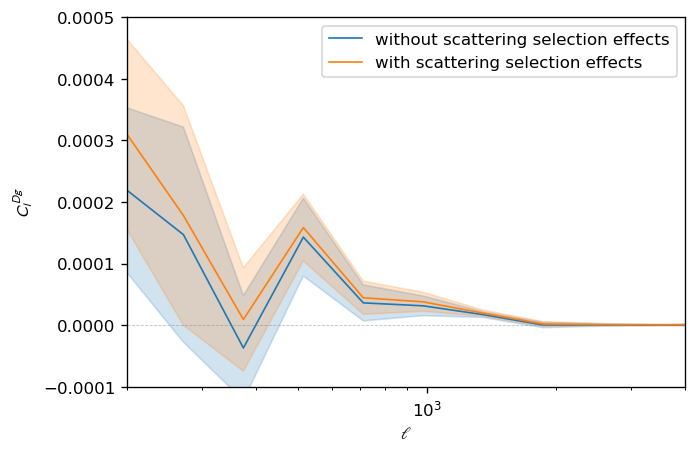

In [ ]:
# one region

fig, ax = plt.subplots()

labels = ('without scattering selection effects', 'with scattering selection effects')
for i, results in enumerate((ClDgs_sfunc, ClDgs)):
    plot_xcorr_trials(ells ,results, color=colorcycle[i], ax=ax, label=labels[i], lw=1, yscale='linear')
ax.set_ylim(-0.0001, 0.0005)
ax.set_xlim(200, 4000)
ax.axhline(0, ls='--', c='gray', alpha=0.5, lw=0.5)
ax.legend()

## galaxy catalog selection effects - apparent magnitude cut

In [48]:
def M_to_m(M, x):
    x_pc = x * 1000 / sim.h
    return 5*np.log10(x_pc) - 5 + M

m_g_cutoff = 25.4
m_g_tightcutoff = 20.7

### visualizing the apparent magnitude cut in region A1

In [49]:
N_g = sim.Ngal_grid(zrange=g_zrange)
delta_g = (N_g - np.mean(N_g)) / np.mean(N_g)
print(np.sum(N_g))

# with apparent magnitude cut
N_g_cutoff = sim.Ngal_grid(zrange=g_zrange, m_g_cutoff=m_g_cutoff)
print(np.sum(N_g_cutoff))
delta_g_cutoff = (N_g_cutoff - np.mean(N_g_cutoff)) / np.mean(N_g_cutoff)

# with a tighter cutoff
N_g_tightcutoff = sim.Ngal_grid(zrange=g_zrange, m_g_cutoff=m_g_tightcutoff)
print(np.sum(N_g_tightcutoff))
delta_g_tightcutoff = (N_g_tightcutoff - np.mean(N_g_tightcutoff)) / np.mean(N_g_tightcutoff)

825708.0
52767.0
12778.0


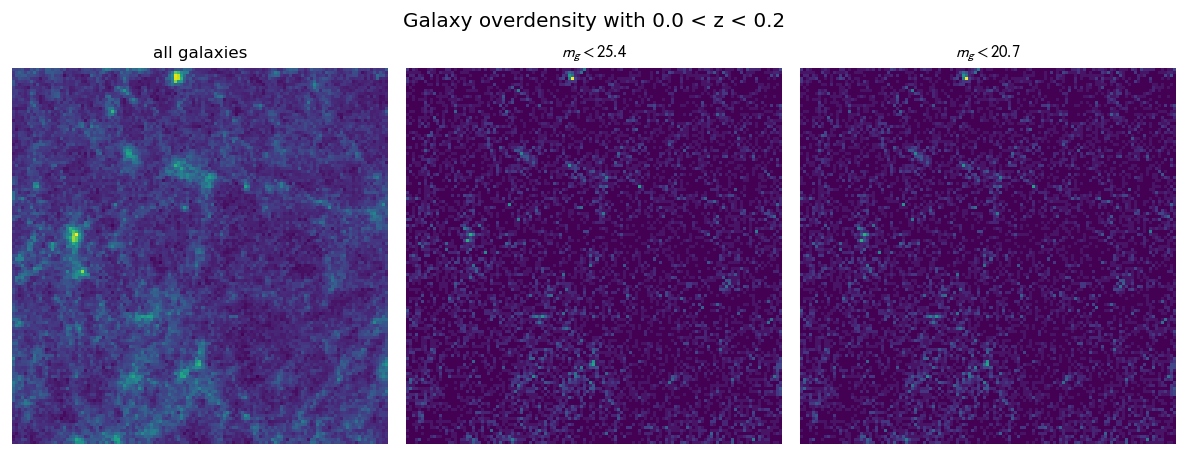

In [9]:
# visualize how m_g cut looks

fig, axes = plt.subplots(1,3,figsize=(10,4))

plt.suptitle(f'Galaxy overdensity with {g_zrange[0]:.1f} < z < {g_zrange[1]:.1f}', y=0.97)

# all galaxies
axes[0].imshow(delta_g)
axes[0].set_title('all galaxies', fontsize=10)

# with apparent magnitude cut
axes[1].imshow(delta_g_tightcutoff)
axes[1].set_title(f'$m_g < {m_g_cutoff:.1f}$', fontsize=10)

# with a tighter cutoff
axes[2].imshow(delta_g_tightcutoff)
axes[2].set_title(f'$m_g < {m_g_tightcutoff:.1f}$', fontsize=10)

for i in range(3):
    axes[i].axis('off')

plt.tight_layout()

### cross-correlating with m-cut catalog

In [120]:
# look at cross-correlation

ntrials = 5
n = 3000 #FRBs
nbins = 10

def sfunc(DM, a=2):
    return np.exp( -(2/3)*(np.log10(DM*a)-3)**2 )

ClDgs, ClDgs_sfunc= {}, {}
ClDgs_midslice = {None: (midslice_ClDg, midslice_DeltaCs)}

cutoffs = (None, m_g_cutoff, m_g_tightcutoff)
delta_gs = (delta_g, delta_g_cutoff, delta_g_tightcutoff)
N_gs = (N_g, N_g_cutoff, N_g_tightcutoff)

# do cross correlation
# FRBs drawn from galaxies weighted by SFR**0.9, see https://arxiv.org/pdf/2207.14316
for i, cutoff in enumerate(cutoffs):
    delta_g_ = delta_gs[i]
    for dict_ in (ClDgs, ClDgs_sfunc):
        dict_[cutoff] = []
    if cutoff is not None:
        ells, ClDg = cross_power_estimator(midslice_DM, delta_g_, s=0.0008, nbins=nbins)
        DeltaCs = get_Clerr(midslice_DM, N_gs[i], nbins=nbins)
        ClDgs_midslice[cutoff] = (np.array(ClDg), np.array(DeltaCs))
    for _ in range(ntrials):
        (DM_sfunc, mult_sfunc), (DM, mult) = sim.sim_DM_grid(N=n, g_df=host_df, DM_sfunc=sfunc, weights=sfr_weight)
        ells, ClDg = cross_oqe(DM_sfunc, delta_g_, mult_sfunc, nbins=nbins)
        ClDgs_sfunc[cutoff].append(np.array(ClDg))
        ells, ClDg = cross_oqe(DM, delta_g_, mult, nbins=nbins)
        ClDgs[cutoff].append(np.array(ClDg))

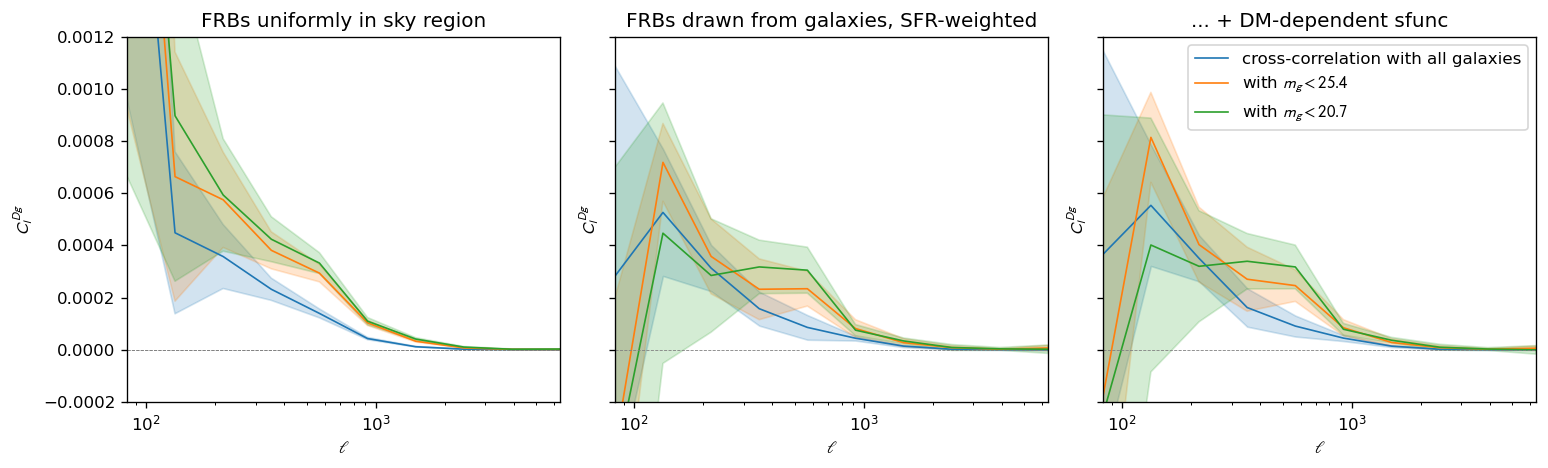

In [121]:
fig, axes = plt.subplots(1,3,figsize=(13,4), sharex=True, sharey=True)

cutoff_labels = ('cross-correlation with all galaxies', f'with $m_g < {m_g_cutoff}$', f'with $m_g < {m_g_tightcutoff}$')
ax = axes[0]
ax.set_title('FRBs uniformly in sky region')
for i, cutoff in enumerate(cutoffs):
    ClDg, DeltaCs = ClDgs_midslice[cutoff]
    plot_xcorr(ells, ClDg, DeltaCs=DeltaCs, ax=ax, color=colorcycle[i], yscale='linear')
ax.axhline(y=0, color='gray', ls='--', lw=0.5)

titles = ('FRBs drawn from galaxies, SFR-weighted', '... + DM-dependent sfunc')
for j, results in enumerate((ClDgs, ClDgs_sfunc)):
    ax = axes[j+1]
    ax.set_title(titles[j])
    for i, cutoff in enumerate(cutoffs):
        plot_xcorr_trials(ells, results[cutoff], color=colorcycle[i], ax=ax, label=cutoff_labels[i], 
                          lw=1, ylim=(-0.0002, 0.0012), yscale='linear')

ax.legend()
for ax in axes:
    ax.axhline(y=0, color='gray', ls='--', lw=0.5)

plt.tight_layout()

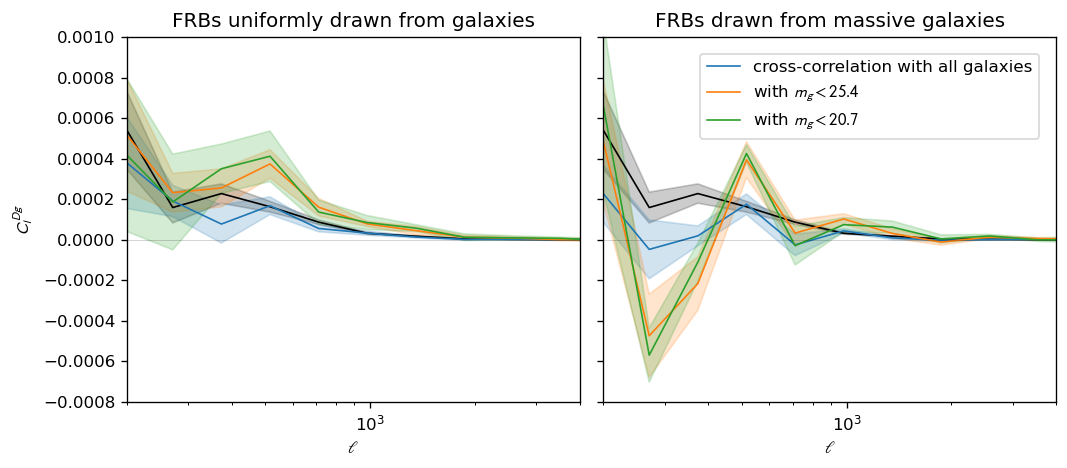

In [18]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharex=True, sharey=True)

cutoffs = (None, m_g_cutoff, m_g_tightcutoff)
labels = ('cross-correlation with all galaxies', f'with $m_g < {m_g_cutoff}$', f'with $m_g < {m_g_tightcutoff}$')
titles = ('FRBs uniformly drawn from galaxies', 'FRBs drawn from massive galaxies')
for i, results in enumerate((ClDgs, ClDgs_gweight)):
    ax = axes[i]
    ax.set_title(titles[i])
    plot_xcorr(ells, midslice_ClDg, DeltaCs=DeltaCs, ax=ax, color='k', yscale='linear')
    for j, cutoff in enumerate(cutoffs):
        plot_xcorr_trials(ells, results[cutoff], color=colorcycle[j], ax=ax, label=labels[j], 
                          lw=1, ylim=(-0.0001, 0.0006), yscale='linear')
    ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
    ax.set_xlim(200, 4000)
axes[0].set_ylim(-0.0008, 0.001)
axes[1].set_ylabel('')
axes[1].legend(borderaxespad=1)
plt.tight_layout()

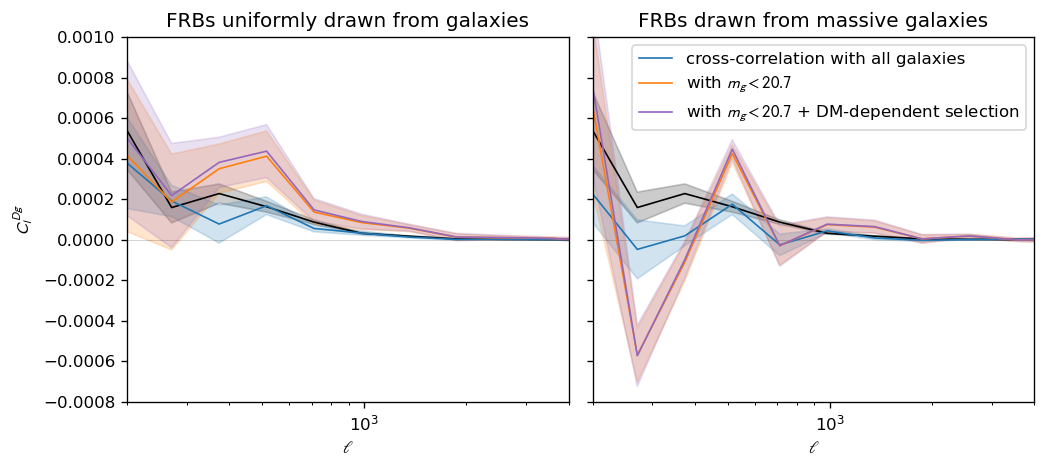

In [22]:
# plot DM-dependent selection effects

fig, axes = plt.subplots(1,2,figsize=(9,4), sharex=True, sharey=True)
cutoff = m_g_tightcutoff # only plot one cutoff for clarity

cutoffs = (None, cutoff)
labels = ('cross-correlation with all galaxies', f'with $m_g < {cutoff}$')
titles = ('FRBs uniformly drawn from galaxies', 'FRBs drawn from massive galaxies')
for i, results in enumerate((ClDgs, ClDgs_gweight)):
    ax = axes[i] 
    plot_xcorr(ells, midslice_ClDg, DeltaCs=DeltaCs, ax=ax, color='k')
    ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
    for j, cutoff_ in enumerate(cutoffs):
        plot_xcorr_trials(ells, results[cutoff_], color=colorcycle[j], ax=ax, label=labels[j], lw=1)

for i, results in enumerate((ClDgs_sfunc, ClDgs_gweight_sfunc)):
    label = f'with $m_g < {cutoff}$ + DM-dependent selection'
    ax = axes[i]
    ax.set_title(titles[i])
    plot_xcorr_trials(ells, results[cutoff], color=colorcycle[4], ax=ax, label=label, lw=1, yscale='linear')
    ax.set_xlim(200, 4000)
    ax.set_ylim(-0.0008, 0.001)

axes[1].set_ylabel('')
axes[1].legend()
plt.tight_layout()

In [23]:
# repeat imposing mult <= 1

ntrials = 10
a=2 #for sfunc
n = 3000 #FRBs
nbins=15

midslice_DM = sim.DM_grid(x_max=np.mean(sim.comoving_distance(frb_zrange)))
ells, midslice_ClDg = cross_power_estimator(midslice_DM, delta_g, s=s, nbins=nbins)
DeltaCs = get_Clerr(midslice_DM, N_g, s, nbins)

def sfunc(DM, a=2):
    return np.exp( -(2/3)*(np.log10(DM*a)-3)**2 )

# do cross correlation
ClDgs, ClDgs_gweight = {}, {}
ClDgs_sfunc, ClDgs_gweight_sfunc = {}, {}
for cutoff, delta_g_ in zip((None, m_g_cutoff, m_g_tightcutoff), (delta_g, delta_g_cutoff, delta_g_tightcutoff)):
    for dict_ in (ClDgs, ClDgs_gweight, ClDgs_sfunc, ClDgs_gweight_sfunc):
        dict_[cutoff] = []
    for _ in range(ntrials):
        # no galaxy weighting
        (DM_sfunc, mult_sfunc), (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, sfunc=sfunc, a=a)
        mult_sfunc[mult_sfunc > 1] = 1
        mult[mult > 1] = 1
        ells, ClDg = cross_oqe(DM_sfunc, delta_g_, mult_sfunc, nbins=nbins)
        ClDgs_sfunc[cutoff].append(np.array(ClDg))
        ells, ClDg = cross_oqe(DM, delta_g_, mult, nbins=nbins)
        ClDgs[cutoff].append(np.array(ClDg))

        # FRBs drawn from galaxies, mass-weighted
        (DM_sfunc, mult_sfunc), (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, sfunc=sfunc, a=a, weights='Mass')
        mult_sfunc[mult_sfunc > 1] = 1
        mult[mult > 1] = 1
        ells, ClDg = cross_oqe(DM_sfunc, delta_g_, mult_sfunc, nbins=nbins)
        ClDgs_gweight_sfunc[cutoff].append(np.array(ClDg))
        ells, ClDg = cross_oqe(DM, delta_g_, mult, nbins=nbins)
        ClDgs_gweight[cutoff].append(np.array(ClDg))

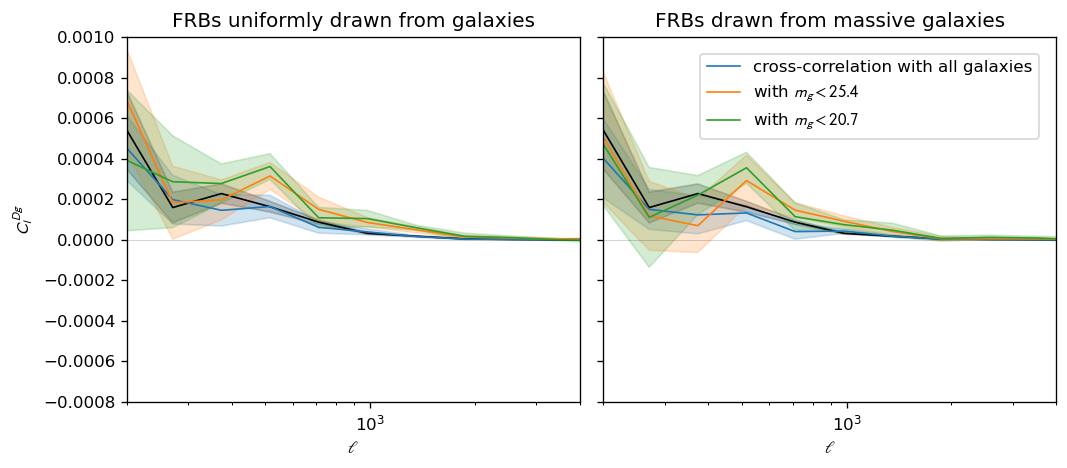

In [24]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharex=True, sharey=True)

cutoffs = (None, m_g_cutoff, m_g_tightcutoff)
labels = ('cross-correlation with all galaxies', f'with $m_g < {m_g_cutoff}$', f'with $m_g < {m_g_tightcutoff}$')
titles = ('FRBs uniformly drawn from galaxies', 'FRBs drawn from massive galaxies')
for i, results in enumerate((ClDgs, ClDgs_gweight)):
    ax = axes[i]
    ax.set_title(titles[i])
    plot_xcorr(ells, midslice_ClDg, DeltaCs=DeltaCs, ax=ax, color='k', yscale='linear')
    for j, cutoff in enumerate(cutoffs):
        plot_xcorr_trials(ells, results[cutoff], color=colorcycle[j], ax=ax, label=labels[j], 
                          lw=1, ylim=(-0.0001, 0.0006), yscale='linear')
    ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
    ax.set_xlim(200, 4000)
axes[0].set_ylim(-0.0008, 0.001)
axes[1].set_ylabel('')
axes[1].legend(borderaxespad=1)
plt.tight_layout()

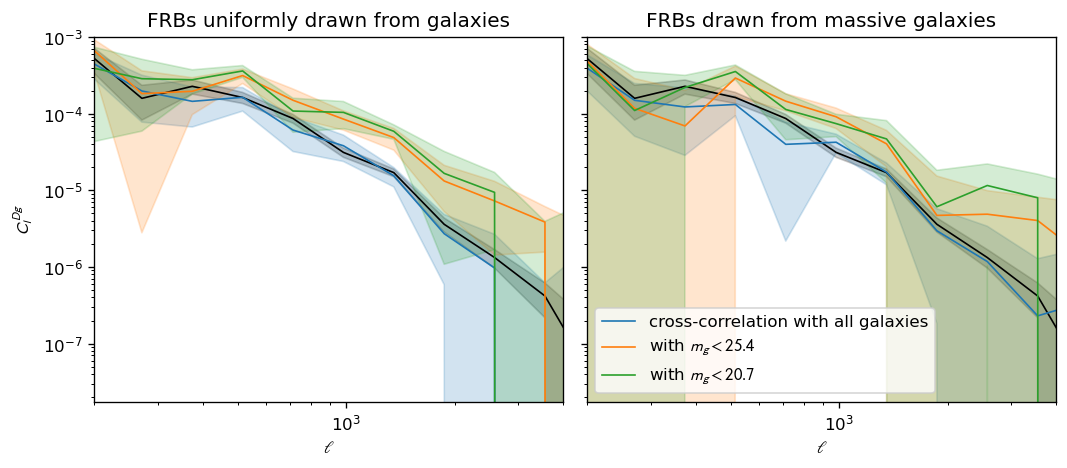

In [25]:
#logscale

fig, axes = plt.subplots(1,2,figsize=(9,4), sharex=True, sharey=True)

cutoffs = (None, m_g_cutoff, m_g_tightcutoff)
labels = ('cross-correlation with all galaxies', f'with $m_g < {m_g_cutoff}$', f'with $m_g < {m_g_tightcutoff}$')
titles = ('FRBs uniformly drawn from galaxies', 'FRBs drawn from massive galaxies')
for i, results in enumerate((ClDgs, ClDgs_gweight)):
    ax = axes[i]
    ax.set_title(titles[i])
    plot_xcorr(ells, midslice_ClDg, DeltaCs=DeltaCs, ax=ax, color='k')
    for j, cutoff in enumerate(cutoffs):
        plot_xcorr_trials(ells, results[cutoff], color=colorcycle[j], ax=ax, label=labels[j], lw=1)
    ax.set_xlim(200, 4000)
    ax.set_ylim(top=1e-3)
axes[1].set_ylabel('')
axes[1].legend()
plt.tight_layout()

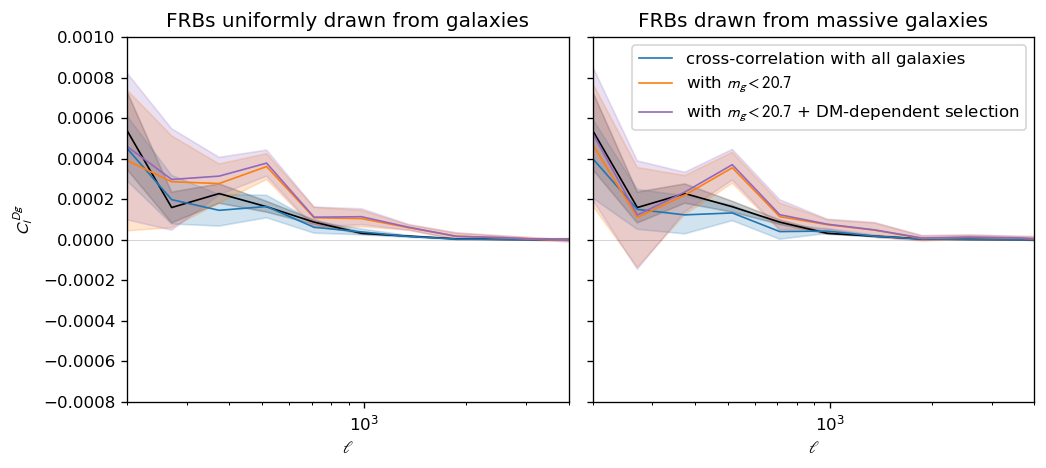

In [26]:
# plot DM-dependent selection effects

fig, axes = plt.subplots(1,2,figsize=(9,4), sharex=True, sharey=True)
cutoff = m_g_tightcutoff # only plot one cutoff for clarity

cutoffs = (None, cutoff)
labels = ('cross-correlation with all galaxies', f'with $m_g < {cutoff}$')
titles = ('FRBs uniformly drawn from galaxies', 'FRBs drawn from massive galaxies')
for i, results in enumerate((ClDgs, ClDgs_gweight)):
    ax = axes[i] 
    plot_xcorr(ells, midslice_ClDg, DeltaCs=DeltaCs, ax=ax, color='k')
    ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
    for j, cutoff_ in enumerate(cutoffs):
        plot_xcorr_trials(ells, results[cutoff_], color=colorcycle[j], ax=ax, label=labels[j], lw=1)

for i, results in enumerate((ClDgs_sfunc, ClDgs_gweight_sfunc)):
    label = f'with $m_g < {cutoff}$ + DM-dependent selection'
    ax = axes[i]
    ax.set_title(titles[i])
    plot_xcorr_trials(ells, results[cutoff], color=colorcycle[4], ax=ax, label=label, lw=1, yscale='linear')
    ax.set_xlim(200, 4000)
    ax.set_ylim(-0.0008, 0.001)

axes[1].set_ylabel('')
axes[1].legend()
plt.tight_layout()

## playing around with FRB galaxy placements, host DM

In [9]:
g_zrange = (0,0.2)

g_df = sim.read_shell_galaxies(g_zrange)
g_df

Mass  Stellar Mass  SFR  Half mass radius           M_V  \
0       12.325589      0.368079  0.0         16.909029 -1.887026e+01   
1        4.735382      0.099735  0.0         16.747738 -1.738517e+01   
2        3.680876      0.017005  0.0         14.356528 -1.583512e+01   
3        1.276706      0.001444  0.0          8.052024 -1.288157e+01   
4        0.422243      0.000000  0.0          8.048302  1.000000e+37   
...           ...           ...  ...               ...           ...   
174674   0.079669      0.000000  0.0         13.499639  1.000000e+37   
174675   0.103569      0.000000  0.0          3.174292  1.000000e+37   
174676   0.079669      0.000000  0.0         15.199003  1.000000e+37   
174677   0.083652      0.000000  0.0         14.041286  1.000000e+37   
174678   0.095602      0.000000  0.0         12.738860  1.000000e+37   

                 M_g              x    theta_      phi_  ipix  
0      -1.847412e+01   34793.821342  1.521240 -0.025828    30  
1      -1.703241e+01   35634.031023  1.524807 -0.026714   654  
2      -1.550031e+01   35827.786589  1.528507 -0.020401  1161  
3      -1.259169e+01   35632.971350  1.526110 -0.029116   776  
4       1.000000e+37   35731.501691  1.524594 -0.026521   529  
...              ...            ...       ...       ...   ...  
174674  1.000000e+37  526184.565770  1.567365 -0.033277  7270  
174675  1.000000e+37  524118.036809  1.576125 -0.035345  8643  
174676  1.000000e+37  525683.422001  1.566316 -0.036050  7017  
174677  1.000000e+37  516376.988317  1.571384 -0.022606  7909  
174678  1.000000e+37  528671.010052  1.571601 -0.034142  7894  

[825708 rows x 10 columns]

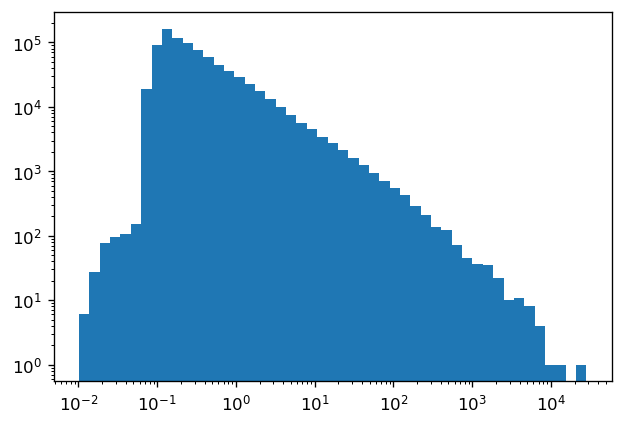

In [ ]:
bins = np.logspace(np.log10(np.amin(g_df['Mass'])), np.log10(np.amax(g_df['Mass'])), 50)
_ = plt.hist(g_df['Mass'], bins=bins)
plt.yscale('log')
plt.xscale('log')

### mass weighting

In [27]:
zrange = (0.3, 0.4) #frbs
g_zrange = (0, 0.2)

N_g = sim.Ngal_grid(g_zrange)
delta_g = N_g/np.mean(N_g) - 1

g_df = sim.read_shell_galaxies(zrange) #draw frbs from here

In [38]:
ntrials = 10
a=2 #for sfunc
n = 3000 #FRBs
nbins=15

# no galaxy weighting
ClDgs_sfunc, ClDgs = [], []
ClDgs_gweight_sfunc, ClDgs_gweight = [], []
ClDgs_sfr_sfunc, ClDgs_sfr = [], []
for _ in range(ntrials):
    # no galaxy weighting
    (DM_sfunc, mult_sfunc), (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, sfunc=sfunc, a=a)
    ells, ClDg = cross_oqe(DM_sfunc, delta_g, mult_sfunc, nbins=nbins)
    ClDgs_sfunc.append(np.array(ClDg))
    ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
    ClDgs.append(np.array(ClDg))

    # galaxy weighting
    (DM_sfunc, mult_sfunc), (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, weights='Mass', sfunc=sfunc, a=a)
    ells, ClDg = cross_oqe(DM_sfunc, delta_g, mult_sfunc, nbins=nbins)
    ClDgs_gweight_sfunc.append(np.array(ClDg))
    ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
    ClDgs_gweight.append(np.array(ClDg))

    # SFR weighting
    (DM_sfunc, mult_sfunc), (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, weights='SFR', sfunc=sfunc, a=a)
    ells, ClDg = cross_oqe(DM_sfunc, delta_g, mult_sfunc, nbins=nbins)
    ClDgs_sfr_sfunc.append(np.array(ClDg))
    ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
    ClDgs_sfr.append(np.array(ClDg))

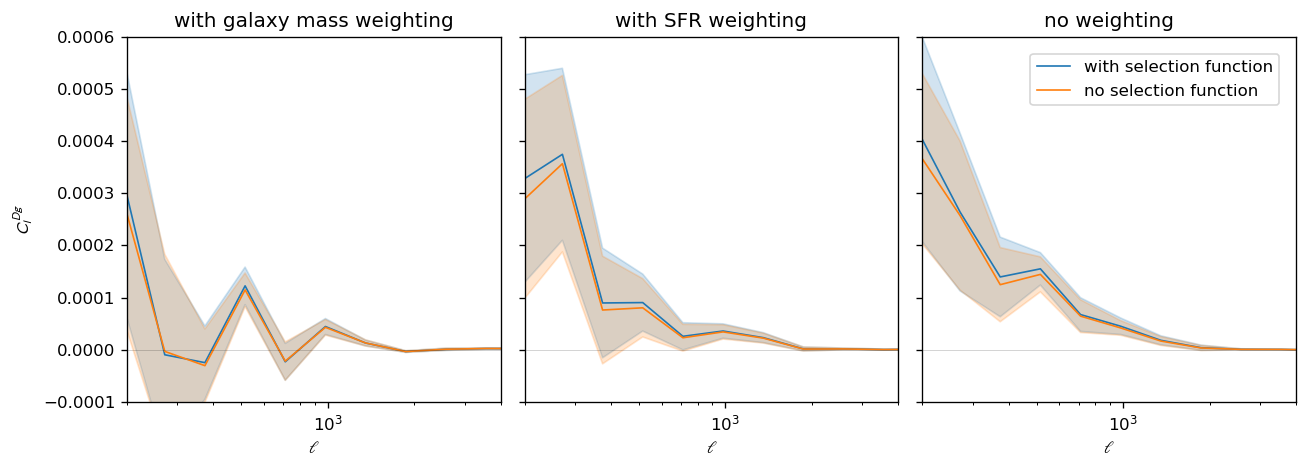

In [58]:
fig, axes = plt.subplots(1,3,figsize=(11,4), sharex=True, sharey=True)

titles = ('with galaxy mass weighting', 'with SFR weighting', 'no weighting')
labels = ('with selection function', 'no selection function')
for i, results in enumerate(((ClDgs_gweight_sfunc, ClDgs_gweight), (ClDgs_sfr_sfunc, ClDgs_sfr), (ClDgs_sfunc, ClDgs))):
    ax = axes[i]
    ax.set_title(titles[i])
    for j, ClDgs_arr in enumerate(results):
        plot_xcorr_trials(ells, ClDgs_arr, color=colorcycle[j], ax=ax, label=labels[j], lw=1, ylim=(-0.0001, 0.0006), yscale='linear')
    ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
    ax.set_xlim(200, 4000)
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[2].legend(borderaxespad=1)
plt.tight_layout()
    

I'm guessing this is probably because the DM contribution from the galaxy goes up a lot. Let's check this:

In [28]:
mean_x = np.mean(sim.comoving_distance(zrange))
midslice_DM = sim.DM_grid(x_max=mean_x)

(DM, mult) = sim.sim_DM_grid(N=10000, g_df=g_df, weights='Mass')

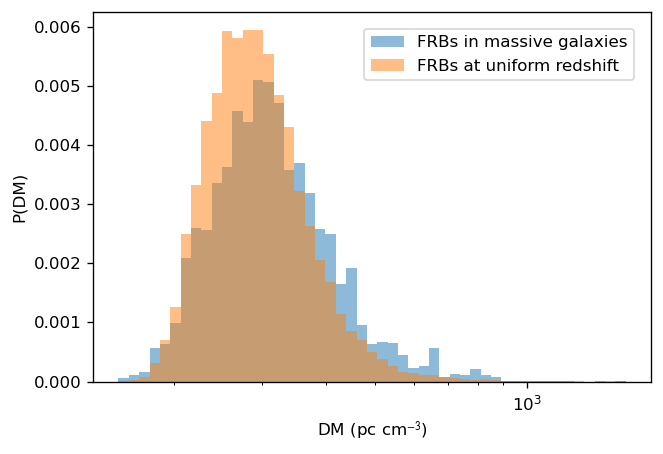

In [31]:
## seeing how much DM variance big galaxies contribute

bins = np.logspace(np.log10(np.amin(midslice_DM)), np.log10(np.amax(DM)), 50)
_ = plt.hist(DM[DM > 0].flatten(), bins=bins, alpha=0.5, density=True, weights=mult[DM > 0].flatten(), label='FRBs in massive galaxies')
_ = plt.hist(midslice_DM.flatten(), bins=bins, alpha=0.5, density=True, label='FRBs at uniform redshift')
plt.xlabel(r'DM (pc cm$^{-3}$)')
plt.ylabel('P(DM)')
plt.xscale('log')
plt.legend(borderaxespad=1)

In [32]:
print(f'FRBs in massive galaxies: DM = {np.mean(DM[DM > 0]):.0f} +/- {np.std(DM[DM > 0]):.0f}')
print(f'FRBs at uniform redshift: DM = {np.mean(midslice_DM):.0f} +/- {np.std(midslice_DM):.0f}')

FRBs in massive galaxies: DM = 328 +/- 105
FRBs at uniform redshift: DM = 324 +/- 104


seems like the host DM variance isn't even that much bigger!

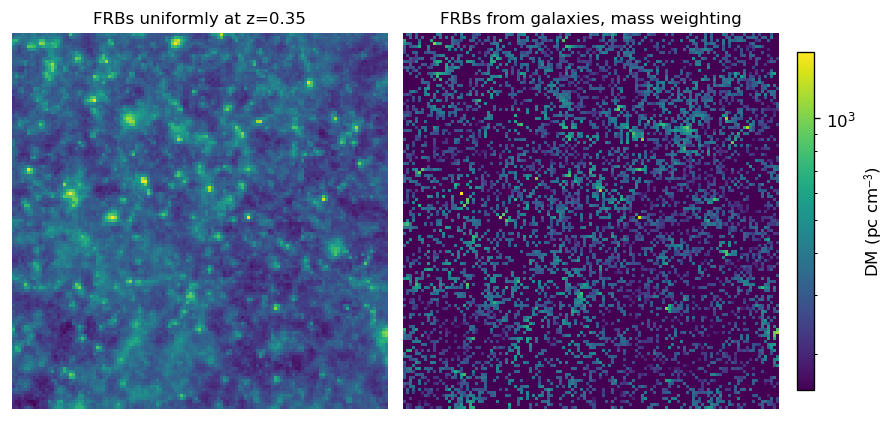

In [13]:
fig, axes = plt.subplots(1,2,figsize=(8,5))
DM_min = np.amin(DM[DM > 0])
DM_max = np.amax(DM)

# all DM
axes[0].imshow(midslice_DM, norm=LogNorm(vmin=DM_min, vmax=DM_max, clip=True))
axes[0].set_title(f'FRBs uniformly at z={sim.z_from_dist(mean_x):.2f}', fontsize=10)

# mass weighting
im = axes[1].imshow(DM, norm=LogNorm(vmin=DM_min, vmax=DM_max, clip=True))
axes[1].set_title('FRBs from galaxies, mass weighting', fontsize=10)

axes[0].axis('off')
axes[1].axis('off')

plt.tight_layout()

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label(r'DM (pc cm$^{-3}$)', fontsize=10)

### isolating effect of host DM galaxy (injecting DM noise)

In [42]:
## isolating the effect of host DM galaxy by comparing to modelled DM noise

ntrials = 10
n = 3000 #FRBs
nbins=15
s = 0.0008

# no galaxy weighting, injected DM noise
# using log-normal fitted in https://arxiv.org/pdf/2007.13935, table 3 z=0.4
mu, sigma = np.log(43), 1.26
hostDM = np.random.lognormal(mu, sigma, DM.shape)
hostDM[mult > 0] /= mult[mult > 0]
hostDM[mult == 0] = 0
hostDM[mult > 0] -= np.mean(hostDM[mult > 0]) #normalize to 0 mean
ells, ClDg_hostDM = cross_power_estimator(midslice_DM+hostDM, delta_g, s=s, nbins=nbins)
ells, ClDg = cross_power_estimator(midslice_DM, delta_g, s=s, nbins=nbins)
DeltaCs = get_Clerr(midslice_DM, N_g, s, nbins)

ClDgs, ClDgs_gweight = [], []
for _ in range(ntrials):

    # no galaxy weighting
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df)
    ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
    ClDgs.append(np.array(ClDg))

    # galaxy weighting
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, weights='Mass')
    ells, ClDg = cross_oqe(DM, delta_g, mult, nbins=nbins)
    ClDgs_gweight.append(np.array(ClDg))
    

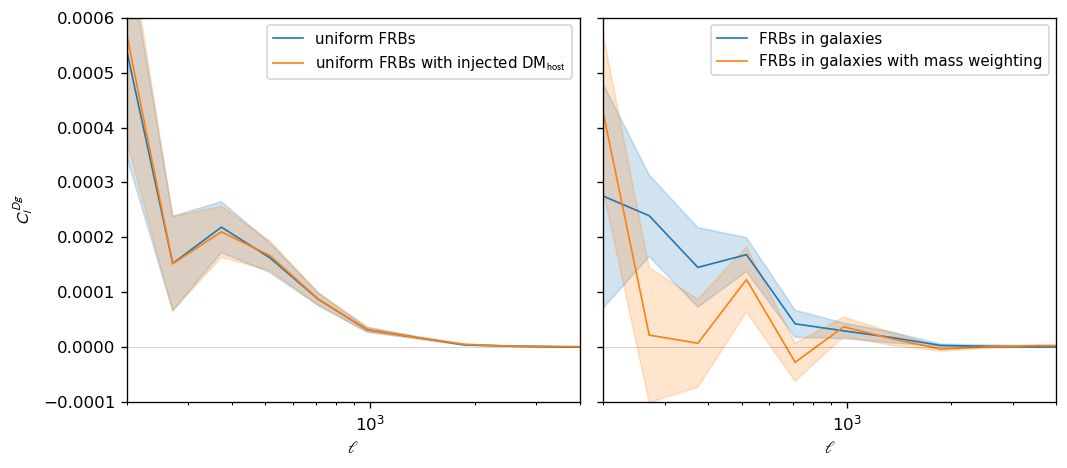

In [46]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharex=True, sharey=True)

plot_xcorr(ells, ClDg, DeltaCs=DeltaCs, color=colorcycle[0], ax=axes[0], 
           label=r'uniform FRBs', lw=1)
plot_xcorr(ells, ClDg_hostDM, DeltaCs=DeltaCs, color=colorcycle[1], ax=axes[0], 
           label=r'uniform FRBs with injected DM$_{\text{host}}$', lw=1, ylim=(-0.0001, 0.0006), yscale='linear')

labels = ('FRBs in galaxies', 'FRBs in galaxies with mass weighting')
for i, results in enumerate((ClDgs, ClDgs_gweight)):
    plot_xcorr_trials(ells ,results, color=colorcycle[i], ax=axes[1], label=labels[i], lw=1, 
                      ylim=(-0.0001, 0.0006), yscale='linear', ylabel='')

for ax in axes:
    ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
    ax.set_xlim(200, 4000)
    ax.legend(fontsize=9)

plt.tight_layout()

### isolating effect of the placement of FRBs

In [25]:
# testing the effect of choices of DM positions

ntrials = 10
n = 3000 #FRBs
nbins=15
s = 0.0008

ClDg_midslice_anygals, ClDg_midslice_rand, ClDg_midslice_gals = [], [], []

for _ in range(ntrials):

    # placing FRBs in the sky positions of massive galaxies
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, weights='Mass')
    midslice_DM_gals = midslice_DM * (mult > 0)
    ells, ClDg_midslice_gal = cross_oqe(midslice_DM_gals, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_gals.append(np.array(ClDg_midslice_gal))

    # placing FRBs in the sky positions of all galaxies
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df)
    midslice_DM_anygals = midslice_DM * (mult > 0)
    ells, ClDg_midslice_gal = cross_oqe(midslice_DM_anygals, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_anygals.append(np.array(ClDg_midslice_gal))

    # placing FRBs in random sky positions
    N = len(DM)
    mult_inds = np.random.choice(N**2, n, replace=True)
    mult = np.zeros(N**2)
    np.add.at(mult, mult_inds, 1)
    mult = mult.reshape((N,N))
    midslice_DM_rand = midslice_DM * (mult > 0)
    ells, ClDg_rand = cross_oqe(midslice_DM_rand, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_rand.append(np.array(ClDg_rand))

(-0.5, 124.5, 124.5, -0.5)

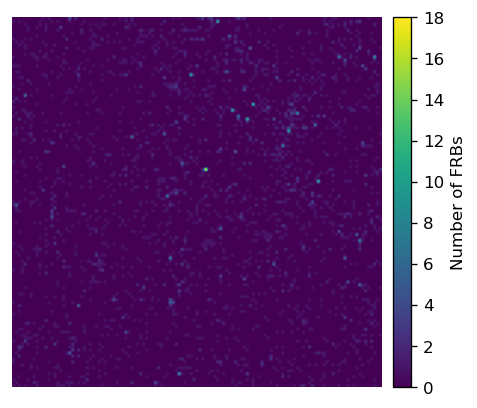

In [27]:
## the FRBs are quite concentrated

fig, ax = plt.subplots()
(DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, weights='Mass') #3000 FRBs total
im = plt.imshow(mult) 
cbar = fig.colorbar(im, ax=ax,  pad=0.02)
cbar.set_label(r'Number of FRBs', fontsize=10)
ax.axis('off')

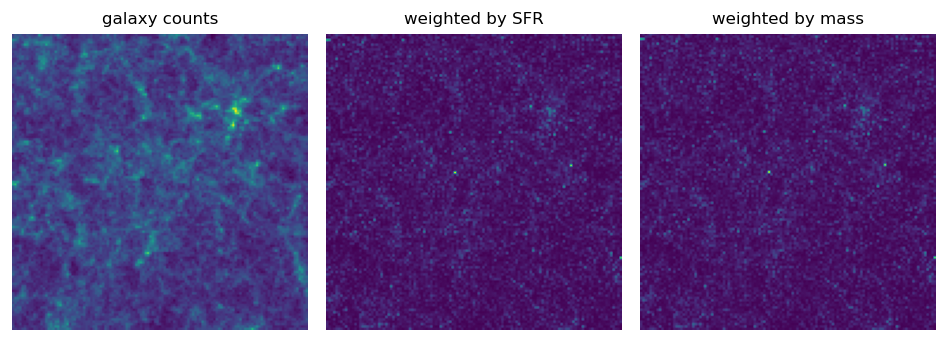

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(8,3))

# all galaxies
N_g = sim.Ngal_grid()
axes[0].imshow((N_g - np.mean(N_g))/np.mean(N_g))
axes[0].set_title('galaxy counts', fontsize=10)

# weight by SFR
N_g_SFR = np.zeros(len(N_g)**2)
np.add.at(N_g_SFR, df['ipix'], df['SFR'])
N_g_SFR = N_g_SFR.reshape(N_g.shape)
axes[1].imshow((N_g_SFR - np.mean(N_g_SFR))/np.mean(N_g_SFR))
axes[1].set_title('weighted by SFR', fontsize=10)

# weight by mass
N_g_m = np.zeros(len(N_g)**2)
np.add.at(N_g_m, df['ipix'], df['Mass'])
N_g_m = N_g_SFR.reshape(N_g.shape)
axes[2].imshow((N_g_m - np.mean(N_g_m))/np.mean(N_g_m))
axes[2].set_title('weighted by mass', fontsize=10)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

plt.tight_layout()

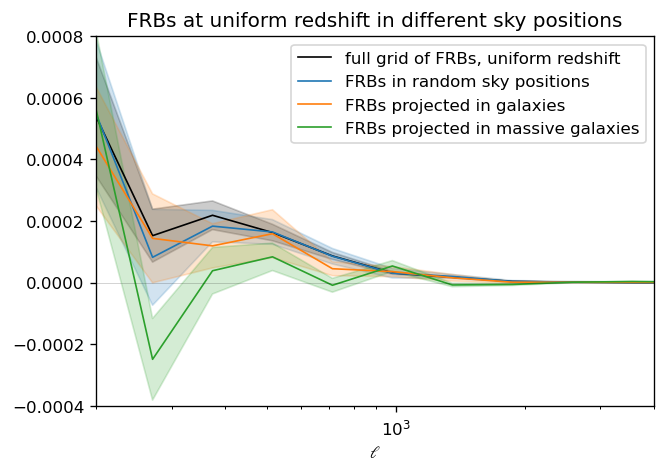

In [61]:
fig, ax = plt.subplots()

plot_xcorr(ells, ClDg, DeltaCs=DeltaCs, color='k', ax=ax, label=r'full grid of FRBs, uniform redshift', lw=1)

ax.set_title('FRBs at uniform redshift in different sky positions')
labels = ('FRBs in random sky positions', 'FRBs projected in galaxies', 'FRBs projected in massive galaxies')
for i, results in enumerate((ClDg_midslice_rand, ClDg_midslice_anygals, ClDg_midslice_gals)):
    plot_xcorr_trials(ells ,results, color=colorcycle[i], ax=ax, label=labels[i], lw=1, 
                      ylim=(-0.0004, 0.0008), yscale='linear', ylabel='')

ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
ax.set_xlim(200, 4000)
ax.legend()

The dominant suppressing effect seems to be because FRBs are positionally inside massive galaxies -- why??

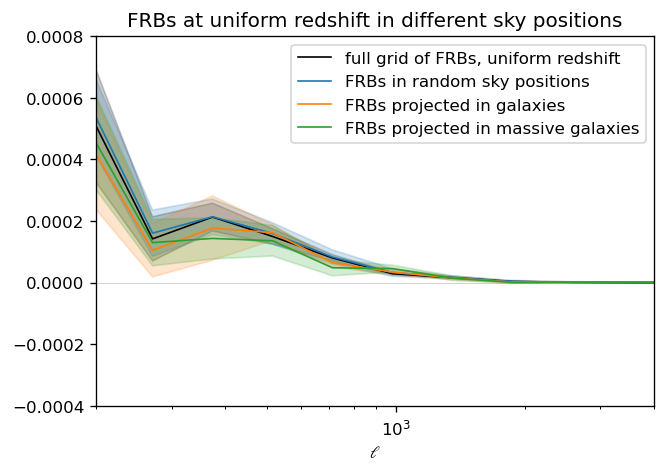

In [31]:
# maybe effect is because there are too many FRBs in a pixel? let's try max one FRB per pixel

ells, ClDg = cross_power_estimator(midslice_DM, delta_g, s=s, nbins=nbins)
DeltaCs = get_Clerr(midslice_DM, N_g, s, nbins)

ClDg_midslice_anygals, ClDg_midslice_rand, ClDg_midslice_gals = [], [], []

for _ in range(ntrials):

    # placing FRBs in the sky positions of massive galaxies
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, weights='Mass')
    mult[ mult > 1 ] = 1
    midslice_DM_gals = midslice_DM * (mult > 0)
    ells, ClDg_midslice_gal = cross_oqe(midslice_DM_gals, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_gals.append(np.array(ClDg_midslice_gal))

    # placing FRBs in the sky positions of all galaxies
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df)
    mult[ mult > 1 ] = 1
    midslice_DM_anygals = midslice_DM * (mult > 0)
    ells, ClDg_midslice_gal = cross_oqe(midslice_DM_anygals, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_anygals.append(np.array(ClDg_midslice_gal))

    # placing FRBs in random sky positions
    N = len(DM)
    mult_inds = np.random.choice(N**2, n, replace=False)
    mult = np.zeros(N**2)
    np.add.at(mult, mult_inds, 1)
    mult = mult.reshape((N,N))
    midslice_DM_rand = midslice_DM * (mult > 0)
    ells, ClDg_rand = cross_oqe(midslice_DM_rand, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_rand.append(np.array(ClDg_rand))

fig, ax = plt.subplots()

plot_xcorr(ells, ClDg, DeltaCs=DeltaCs, color='k', ax=ax, label=r'full grid of FRBs, uniform redshift', lw=1)

ax.set_title('FRBs at uniform redshift in different sky positions')
labels = ('FRBs in random sky positions', 'FRBs projected in galaxies', 'FRBs projected in massive galaxies')
for i, results in enumerate((ClDg_midslice_rand, ClDg_midslice_anygals, ClDg_midslice_gals)):
    plot_xcorr_trials(ells ,results, color=colorcycle[i], ax=ax, label=labels[i], lw=1, 
                      ylim=(-0.0004, 0.0008), yscale='linear', ylabel='')

ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
ax.set_xlim(200, 4000)
ax.legend()

As expected, overweighting certain pixels kills the signal. I don't think it makes sense to overweight pixels with multiple FRBs when it's not actually removing uncorrelated (i.e. measurement) noise

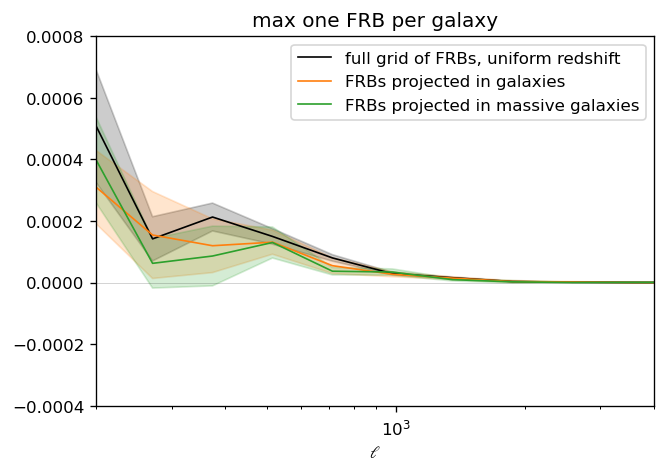

In [32]:
# what about limiting to different galaxies?

ells, ClDg = cross_power_estimator(midslice_DM, delta_g, s=s, nbins=nbins)
DeltaCs = get_Clerr(midslice_DM, N_g, s, nbins)

ClDg_midslice_anygals, ClDg_midslice_rand, ClDg_midslice_gals = [], [], []

for _ in range(ntrials):

    # placing FRBs in the sky positions of massive galaxies
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, weights='Mass', replace=False)
    mult[ mult > 1 ] = 1
    midslice_DM_gals = midslice_DM * (mult > 0)
    ells, ClDg_midslice_gal = cross_oqe(midslice_DM_gals, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_gals.append(np.array(ClDg_midslice_gal))

    # placing FRBs in the sky positions of all galaxies
    (DM, mult) = sim.sim_DM_grid(N=n, g_df=g_df, replace=False)
    mult[ mult > 1 ] = 1
    midslice_DM_anygals = midslice_DM * (mult > 0)
    ells, ClDg_midslice_gal = cross_oqe(midslice_DM_anygals, delta_g, mult, s=s, nbins=nbins)
    ClDg_midslice_anygals.append(np.array(ClDg_midslice_gal))

fig, ax = plt.subplots()

plot_xcorr(ells, ClDg, DeltaCs=DeltaCs, color='k', ax=ax, label=r'full grid of FRBs, uniform redshift', lw=1)

ax.set_title('max one FRB per galaxy')
labels = ('FRBs projected in galaxies', 'FRBs projected in massive galaxies')
for i, results in enumerate((ClDg_midslice_anygals, ClDg_midslice_gals)):
    plot_xcorr_trials(ells ,results, color=colorcycle[i+1], ax=ax, label=labels[i], lw=1, 
                      ylim=(-0.0004, 0.0008), yscale='linear', ylabel='')

ax.axhline(y=0, color='k', alpha=0.2, lw=0.5)
ax.set_xlim(200, 4000)
ax.legend()

## playing around with DM-dependent selection effects

### look at DM distribution

In [ ]:
zrange = (0.05, 0.4)
sampled_DM, mult = sim.sim_DM_grid(zrange, N=5000)
# midslice_DM = sim.DM_grid(x_max=np.mean(sim.comoving_distance(zrange)))

In [ ]:
chime_dms = pd.read_csv('/home/submit/aqc/frb_project/data/chime_data/chimefrbcat1.csv')['dm_fitb']
chime_bb_dms = pd.read_csv('/home/submit/aqc/frb_project/data/chime_data//basecat1_catalog.csv')['dm']

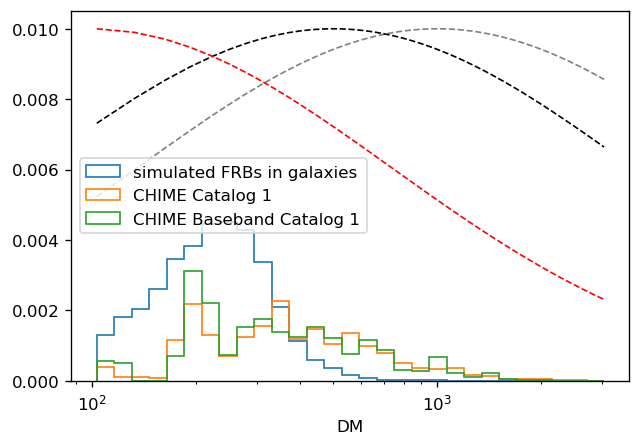

In [ ]:
def sfunc(DMs, a=1): # fiducial selection function
    # a is how many factors to squish the selection function
    return np.exp( -(2/3)*(np.log10(DMs*a)-3)**2 )

bins = np.logspace(np.log10(np.amin(chime_dms)), np.log10(np.amax(chime_dms)), 30)
_ = plt.hist(sampled_DM.flatten(), bins=bins, weights=mult.flatten(), density=True, label='simulated FRBs in galaxies', histtype='step')
# _ = plt.hist(midslice_DM.flatten(), bins=bins, histtype='step', density=True, label='simulated FRBs at uniform redshift')
_ = plt.hist(chime_dms, bins=bins, density=True, label='CHIME Catalog 1', histtype='step')
_ = plt.hist(chime_bb_dms, bins=bins, density=True, label='CHIME Baseband Catalog 1', histtype='step')
plt.plot(np.linspace(bins[0], bins[-1], 100), 0.01*sfunc(np.linspace(bins[0], bins[-1], 100)), color='gray', ls='--', lw=1)
plt.plot(np.linspace(bins[0], bins[-1], 100), 0.01*sfunc(np.linspace(bins[0], bins[-1], 100), a=2), color='k', ls='--', lw=1)
plt.plot(np.linspace(bins[0], bins[-1], 100), 0.01*sfunc(np.linspace(bins[0], bins[-1], 100), a=10), color='r', ls='--', lw=1)
plt.xlabel('DM')
plt.legend()
plt.xscale('log')

### squishing the selection function

In [ ]:
N_g = sim.Ngal_grid((0, 0.2))
delta_g = N_g/np.mean(N_g) - 1

# frbs
zrange = (0.3, 0.4)
midslice_DM = sim.DM_grid(x_max=np.mean(sim.comoving_distance(zrange)))

In [ ]:
# get trials for different values of a
ntrials = 10
a_list = (1,2,3, 10)

sampled_DMs, mults = { a: [] for a in a_list }, { a: [] for a in a_list }
for i, a in enumerate(a_list):
    for _ in range(ntrials):
        (sampled_DM, mult), _ = sim.sim_DM_grid(zrange, N=2000, sfunc=sfunc, a=a)
        sampled_DMs[a].append(sampled_DM)
        mults[a].append(mult)

(array([6.000e+00, 3.400e+01, 2.150e+02, 7.320e+02, 1.328e+03, 1.943e+03,
        2.215e+03, 2.396e+03, 2.087e+03, 1.570e+03, 1.117e+03, 6.870e+02,
        4.650e+02, 2.910e+02, 1.530e+02, 1.070e+02, 9.600e+01, 6.000e+01,
        3.100e+01, 3.700e+01, 1.500e+01, 1.300e+01, 1.200e+01, 5.000e+00,
        2.000e+00, 6.000e+00, 1.000e+00, 0.000e+00, 0.000e+00]),
 array([ 155.53582889,  169.85514572,  185.49276225,  202.57004697,
         221.2195421 ,  241.58599231,  263.82746806,  288.11659252,
         314.64188128,  343.60920554,  375.24338988,  409.78995724,
         447.51703451,  488.7174335 ,  533.71092358,  582.84671351,
         636.50616174,  695.10573628,  759.10024703,  828.98637569,
         905.30653068,  988.65305694, 1079.67283332, 1179.07229319,
        1287.62290729, 1406.16717139, 1535.62514514, 1677.00159295,
        1831.39378232, 2000.        ]),
 <BarContainer object of 29 artists>)

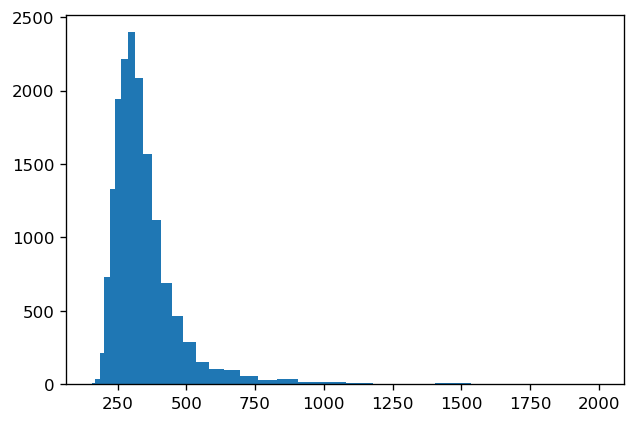

In [ ]:
plt.hist(midslice_DM.flatten(), bins=np.logspace(np.log10(np.amin(midslice_DM)), np.log10(2000), 30))

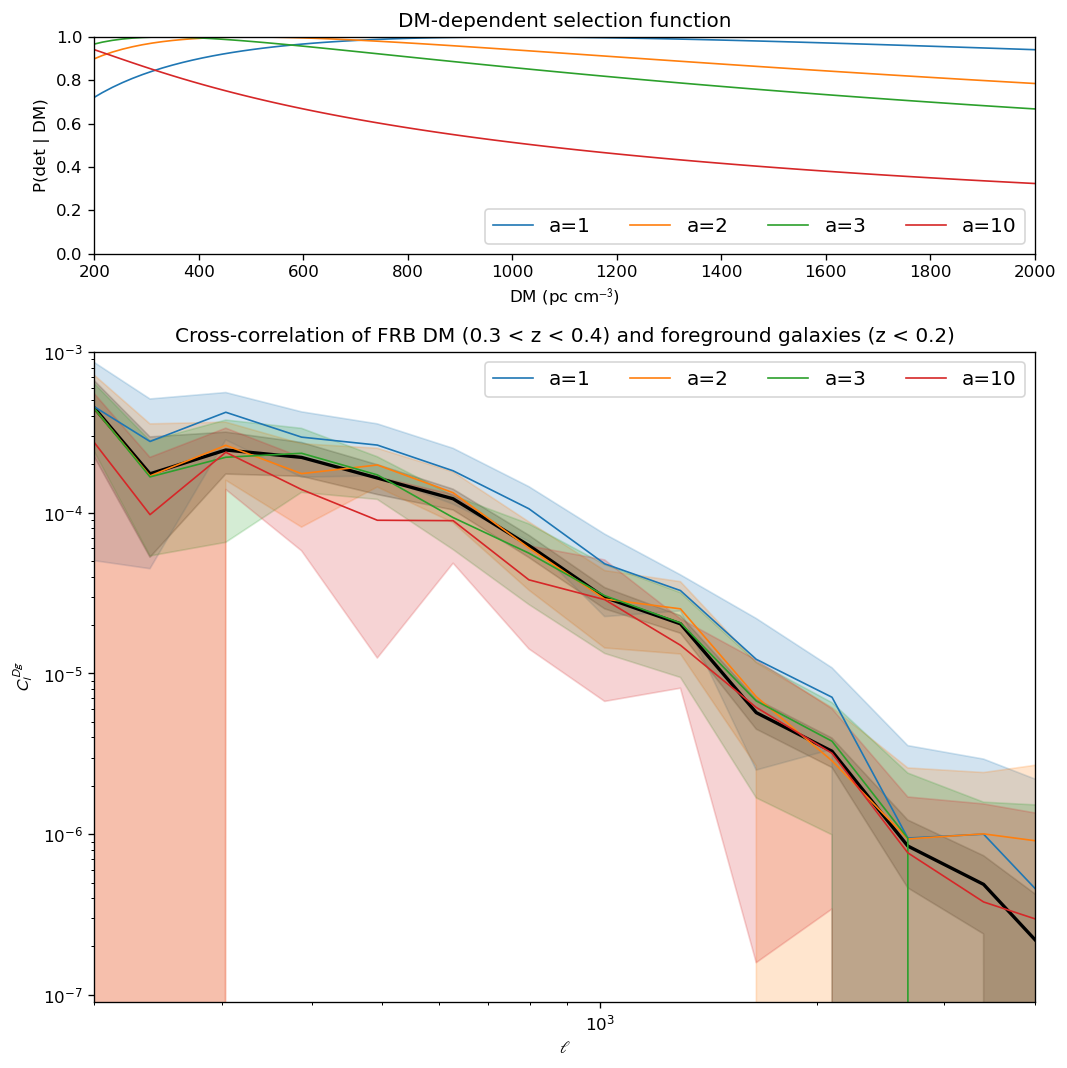

In [ ]:
gs = GridSpec(2, 1, height_ratios=[1, 3])
fig = plt.figure(figsize=(9,9))

ax_s = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

nbins = 20
s = 0.0008

# plot cross correlation
## full-grid cross-correlation, FRBs not in galaxies
ell_mids, ClDg = cross_power_estimator(midslice_DM, delta_g, s, nbins)
DeltaCs = get_Clerr(midslice_DM, N_g, s, nbins)
plot_xcorr(ell_mids, ClDg, ax, DeltaCs=DeltaCs, color='k', lw=2)

## each squishes the sfunc more
for i, a in enumerate(a_list):
    ax_s.plot(np.linspace(100, 2000, 100), sfunc(np.linspace(100, 2000, 100), a=a), color=colorcycle[i], lw=1, label=f'a={a}')
    ClDgs = []
    for j in range(ntrials):
        ells, ClDg = cross_oqe(sampled_DMs[a][j], delta_g, mults[a][j], s, nbins)
        ClDgs.append(ClDg)
    ClDgs = np.vstack(ClDgs)
    mean_ClDg = np.mean(ClDgs, axis=0)
    std_ClDg = np.std(ClDgs, axis=0)
    plot_xcorr(ells, mean_ClDg, ax=ax, DeltaCs=std_ClDg, label=f'a={a}', 
               color=colorcycle[i], lw=1)

ax_s.set_title('DM-dependent selection function')
ax_s.set_xlabel('DM (pc ' + r'cm$^{-3}$)')
ax_s.set_ylabel('P(det | DM)')
ax_s.set_ylim(0,1)
ax_s.set_xlim(200, 2000)

ax_s.legend(fontsize=12, ncol=4, loc='lower right')
ax.legend(fontsize=12, ncol=4, loc='upper right')

ax.set_title('Cross-correlation of FRB DM (0.3 < z < 0.4) and foreground galaxies (z < 0.2)')
ax.set_xlim(200, 4000)
ax.set_ylim(top=1e-3)

plt.tight_layout()

### DM cutoff

(9.059358015572711e-08, 0.001)

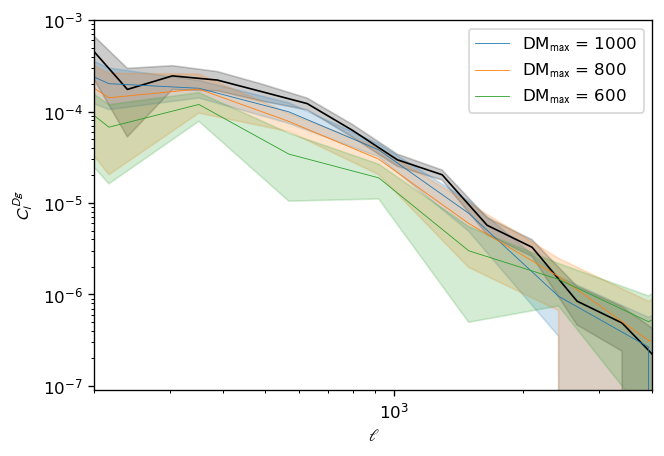

In [ ]:
fig, ax = plt.subplots()

s = 0.0008
ntrials = 10
DM_maxs = (1000, 800, 600)
N = 5000

## full-grid cross-correlation, FRBs not in galaxies
nbins = 20
ell_mids, ClDg = cross_power_estimator(midslice_DM, delta_g, s, nbins)
DeltaCs = get_Clerr(midslice_DM, N_g, s, nbins)
plot_xcorr(ell_mids, ClDg, ax, DeltaCs=DeltaCs, color='k', lw=1)

def sfunc_cutoff(DM, DM_max):
    return np.heaviside(DM_max - DM, 1)

nbins = 10
for i, DM_max in enumerate(DM_maxs):
    ClDgs = []
    for _ in range(ntrials):
        (sampled_DM, mult), _ = sim.sim_DM_grid(zrange, N=N, sfunc=sfunc_cutoff, DM_max=DM_max)
        ells, ClDg = cross_oqe(sampled_DM, delta_g, mult, s, nbins)
        ClDgs.append(ClDg)
    ClDgs = np.vstack(ClDgs)
    mean_ClDg = np.mean(ClDgs, axis=0)
    std_ClDg = np.std(ClDgs, axis=0)
    plot_xcorr(ells, mean_ClDg, ax=ax, DeltaCs=std_ClDg, label=r'DM$_{\text{max}}$' + f' = {DM_max}', 
               color=colorcycle[i], lw=0.5)

ax.legend()

# ax.set_title('Cross-correlation of FRB DM (0.3 < z < 0.4) and foreground galaxies (z < 0.2)')
ax.set_xlim(200, 4000)
ax.set_ylim(top=1e-3)

## looking at properties of the catalog

In [ ]:
df = sim.read_shell_galaxies() #let's take a look at the properties of the galaxies

Text(0, 0.5, 'SFR (M$_\\odot/$yr)')

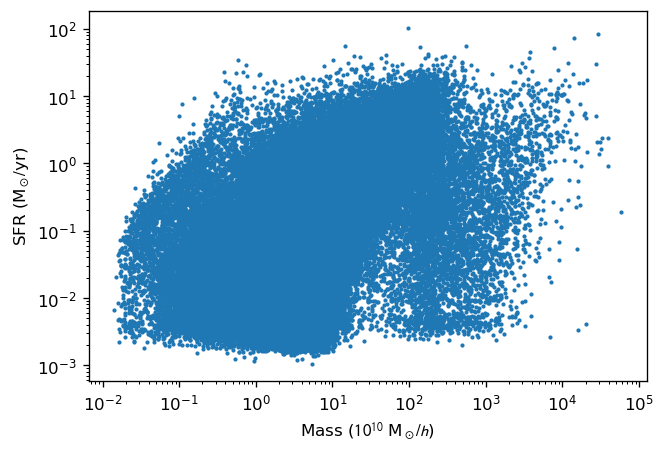

In [26]:
plt.scatter(df['Mass'][df['SFR'] > 0], df['SFR'][df['SFR'] > 0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass ($10^{10}$ M$_\odot/h$)')
plt.ylabel(r'SFR (M$_\odot/$yr)')

## what does having a wider FRB shell do?

In [19]:
mean_z = 0.31
max_zs = (0.34, .37, .40)

zranges = []
mean_x = sim.comoving_distance(mean_z)
for max_z in max_zs:
    zranges.append((float(sim.z_from_dist(mean_x-(sim.comoving_distance(max_z)-mean_x))), max_z))

print(zranges)

[(0.2805077479321215, 0.34), (0.25199699124049485, 0.37), (0.22441897937040017, 0.4)]


In [20]:
midslice_DM = sim.DM_grid(x_max=mean_x)
N_g = sim.Ngal_grid(zrange=(0,0.2)) #foreground galaxies

n = 2000 #FRBs
ntrials = 5

results = { zrange: [] for zrange in zranges }
for zrange in zranges:
    for _ in range(ntrials):
        results[zrange].append(sim.sim_DM_grid(zrange, N=n))

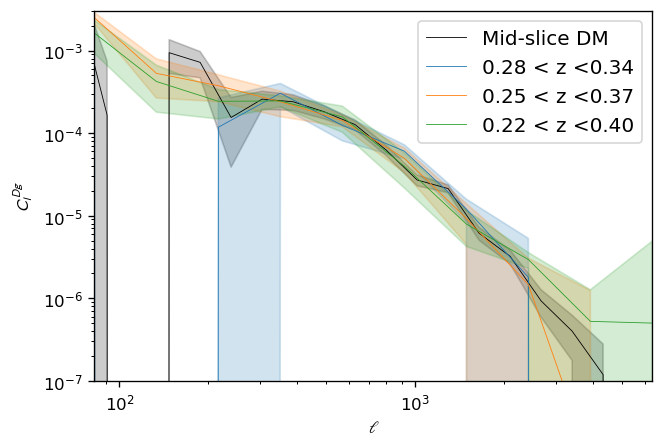

In [22]:
delta_g = N_g/np.mean(N_g) - 1

fig, ax = plt.subplots()

## full-grid cross-correlation, FRBs not in galaxies
nbins=20
ell_mids, ClDg = cross_power_estimator(midslice_DM, delta_g, s, nbins)
DeltaCs = get_Clerr(midslice_DM, N_g, s, nbins)
plot_xcorr(ell_mids, ClDg, ax, DeltaCs=DeltaCs, label='Mid-slice DM', color='k', lw=0.5)

## FRBs in galaxies over a wide range
nbins=10
for i, zrange in enumerate(zranges):
    ClDgs = []
    for DM, frb_mult in results[zrange]:
        ells, ClDg = cross_oqe(DM, delta_g, frb_mult, s, nbins)
        ClDgs.append(ClDg)
    ClDgs = np.vstack(ClDgs)
    mean_ClDg = np.mean(ClDgs, axis=0)
    std_ClDg = np.std(ClDgs, axis=0)
    plot_xcorr(ells, mean_ClDg, ax=ax, DeltaCs=std_ClDg, label=f'{zrange[0]:.2f} < z <{zrange[1]:.2f}', 
               color=colorcycle[i], lw=0.5)

ax.set_yscale('log')
ax.set_ylim(1e-7, 3e-3)
ax.legend(fontsize=12)

Text(0.5, 0, 'DM')

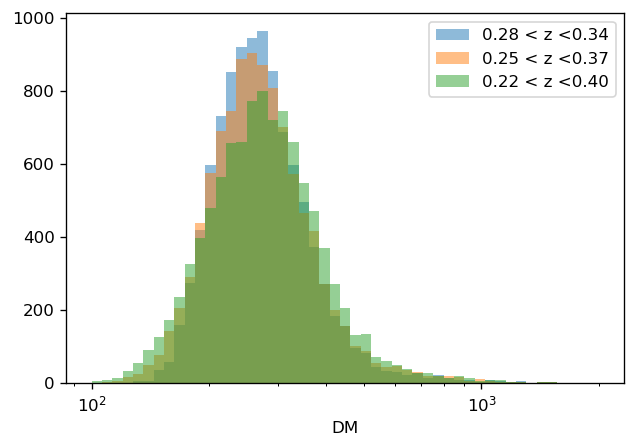

In [63]:
bins = np.logspace(np.log10(100), np.log10(2000), 50)
for zrange in zranges:
    DMs = np.concatenate([i[0].flatten() for i in results[zrange]])
    frb_mults = np.concatenate([i[1].flatten() for i in results[zrange]])
    _ = plt.hist(DMs, bins=bins, alpha=0.5, weights=frb_mults, label=f'{zrange[0]:.2f} < z <{zrange[1]:.2f}')
plt.legend()
plt.xscale('log')
plt.xlabel('DM')